# Solar Adoption Analysis

Research Question:
Conditional on sufficient solar resource and mature technology, what factors are associated with under-adoption, indicating structural barriers?

Scope:
- Limit to United States
- Focus on residential solar

## Project Overview
Analysis of solar adoption patterns across US counties using:
1. **Outcome**: LBNL Tracking the Sun - Solar installations by county
2. **Control**: NREL NSRDB - Solar radiation/irradiance data
3. **Barriers**: US Census/ACS - Demographics (income, homeownership, urbanicity)
4. **Policy**: DSIRE - Net metering policy indicators

## Feature Selection
Feature selection was grounded in established evidence linking socioeconomic, structural, and policy variables to solar adoption outcomes.
For example, several national analyses show that residential solar adopters tend to be higher-income, homeowner households and that these patterns vary significantly across demographic groups and locations (https://emp.lbl.gov/publications/residential-solar-adopter-income-3?).
Policy mechanisms such as net-metering and targeted incentives have been documented to influence adoption patterns and equity outcomes (https://doi.org/10.1038/s41560-020-00724-2). Physical feasibility (solar irradiance and housing type) control for energy potential and practical deployability.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import geopandas as gpd
from pathlib import Path
import warnings
import os
from dotenv import load_dotenv

# Load environment variables from .env file
env_path = Path('.env')
load_dotenv(env_path)

warnings.filterwarnings('ignore')

## 1. LBNL Tracking the Sun - Solar Adoption Data
Download project (installation) level residential solar installation data from LBNL's Tracking the Sun project

The current version of the public data file includes about 3.3 million PV systems installed through year-end
2024

Data Source: https://emp.lbl.gov/tracking-the-sun

In [ ]:
# Load LBNL Tracking the Sun Data
csv_path = 'source_datasets/LBNL_TrackingTheSun2025_PublicDataFile/TTS_LBNL_public_file_29-Sep-2025_all.csv'

# Load the data
tts_df = pd.read_csv(csv_path)

# Configure pandas display options for better visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("=" * 70)
print("LBNL Tracking the Sun Dataset Loaded")
print("=" * 70)
print(f"\nShape: {tts_df.shape}")
print(f"Records: {len(tts_df):,} systems")
print(f"Features: {tts_df.shape[1]} columns")

print(f"\n\nColumn Names ({len(tts_df.columns)} total):")
for i, col in enumerate(tts_df.columns, 1):
    print(f"  {i:2d}. {col}")


# Restrict to residential systems only
# When data is available, residential systems are identified as RES_SF (residential single-family) or
# RES_MF (residential multi-family); in all other cases, residential systems are identified as simply
# RES.
tts_df = tts_df[tts_df['customer_segment'].isin(['RES', 'RES_SF', 'RES_MF'])]

# Missing data are coded in the database as -1. Fill in missing values coded as -1 with NaN for accurate analysis
tts_df.replace(-1, np.nan, inplace=True)

print(f"\n\nData Types:")
print(tts_df.dtypes)

print(f"\n\nFirst 5 rows:")
print(tts_df.head())

print(f"\n\nBasic Statistics:")
print(tts_df.describe())

print(f"\n\nMissing Values Summary:")
missing_counts = tts_df.isnull().sum()
missing_percent = (tts_df.isnull().sum() / len(tts_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(f"\n⚠️  ALERT: {len(missing_df)} columns have missing values:")
    print(missing_df.to_string(index=False))
    print(f"\n  Total missing values: {missing_counts.sum():,}")
    print(f"  Columns with >50% missing: {len(missing_df[missing_df['Missing_Percent'] > 50])}")
else:
    print("✓ No missing values detected!")

print(f"\n\nKey columns for analysis:")
key_cols = ['zip_code', 'city', 'state', 'PV_system_size_DC', 'total_installed_price']
available_key_cols = [col for col in key_cols if col in tts_df.columns]
if available_key_cols:
    print(f"  {', '.join(available_key_cols)}")
    print(f"\n  Sample:")
    print(tts_df[available_key_cols].head(3))

LBNL Tracking the Sun Dataset Loaded

Shape: (3664197, 81)
Records: 3,664,197 systems
Features: 81 columns


Column Names (81 total):
   1. data_provider_1
   2. data_provider_2
   3. system_ID_1
   4. system_ID_2
   5. installation_date
   6. PV_system_size_DC
   7. total_installed_price
   8. rebate_or_grant
   9. customer_segment
  10. expansion_system
  11. multiple_phase_system
  12. TTS_link_ID
  13. new_construction
  14. tracking
  15. ground_mounted
  16. zip_code
  17. city
  18. state
  19. utility_service_territory
  20. third_party_owned
  21. installer_name
  22. self_installed
  23. azimuth_1
  24. azimuth_2
  25. azimuth_3
  26. tilt_1
  27. tilt_2
  28. tilt_3
  29. module_manufacturer_1
  30. module_model_1
  31. module_quantity_1
  32. module_manufacturer_2
  33. module_model_2
  34. module_quantity_2
  35. module_manufacturer_3
  36. module_model_3
  37. module_quantity_3
  38. additional_modules
  39. technology_module_1
  40. technology_module_2
  41. technology_m

In [19]:
# Check how many states are represented in the TTS data
print("\n" + "=" * 70)
print("Checking States Represented in Tracking the Sun Data")
print("=" * 70)
unique_states = tts_df['state'].dropna().unique()
print(f"\nStates represented in TTS data: {len(unique_states)}")
print(f"State codes: {', '.join(sorted(unique_states))}")   


Checking States Represented in Tracking the Sun Data

States represented in TTS data: 27
State codes: AR, AZ, CA, CO, CT, DC, DE, FL, IL, MA, MD, ME, MN, NH, NJ, NM, NY, OH, OR, PA, RI, TX, UT, VA, VT, WA, WI


In [149]:
tts_df[tts_df['state'] == 'ME']

,data_provider_1,data_provider_2,system_ID_1,system_ID_2,installation_date,PV_system_size_DC,total_installed_price,rebate_or_grant,customer_segment,expansion_system,multiple_phase_system,TTS_link_ID,new_construction,tracking,ground_mounted,zip_code,city,state,utility_service_territory,third_party_owned,installer_name,self_installed,azimuth_1,azimuth_2,azimuth_3,tilt_1,tilt_2,tilt_3,module_manufacturer_1,module_model_1,module_quantity_1,module_manufacturer_2,module_model_2,module_quantity_2,module_manufacturer_3,module_model_3,module_quantity_3,additional_modules,technology_module_1,technology_module_2,technology_module_3,BIPV_module_1,BIPV_module_2,BIPV_module_3,bifacial_module_1,bifacial_module_2,bifacial_module_3,nameplate_capacity_module_1,nameplate_capacity_module_2,nameplate_capacity_module_3,efficiency_module_1,efficiency_module_2,efficiency_module_3,inverter_manufacturer_1,inverter_model_1,inverter_quantity_1,inverter_manufacturer_2,inverter_model_2,inverter_quantity_2,inverter_manufacturer_3,inverter_model_3,inverter_quantity_3,additional_inverters,micro_inverter_1,micro_inverter_2,micro_inverter_3,built_in_meter_inverter_1,built_in_meter_inverter_2,built_in_meter_inverter_3,output_capacity_inverter_1,output_capacity_inverter_2,output_capacity_inverter_3,DC_optimizer,inverter_loading_ratio,battery_manufacturer,battery_model,battery_rated_capacity_kW,battery_rated_capacity_kWh,battery_price,technology_type,extensions_multiphase_id,unit_cost_per_kw
26875,Efficiency Maine,-1,3218,-1,2012-10-09,4.410,15109.0,2000.0,RES,False,False,-1,NaN,NaN,NaN,4614,Blue Hill,ME,BHE,NaN,redacted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,NaN,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pv-only,-1,3426.077098
26876,Efficiency Maine,-1,3202,-1,2012-11-06,5.760,18155.0,2000.0,RES,False,False,-1,NaN,NaN,NaN,4496,Winterport,ME,BHE,NaN,redacted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,NaN,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pv-only,-1,3151.909722
26877,Efficiency Maine,-1,3110,-1,2012-09-04,4.320,15997.0,2000.0,RES,False,False,-1,NaN,NaN,NaN,4355,Readfield,ME,CMP,NaN,redacted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,NaN,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pv-only,-1,3703.009259
26878,Efficiency Maine,-1,3241,-1,2012-10-09,4.620,13838.0,2000.0,RES,False,False,-1,NaN,NaN,NaN,4568,So Bristol,ME,CMP,NaN,redacted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,NaN,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pv-only,-1,2995.238095
26879,Efficiency Maine,-1,3168,-1,2012-09-04,10.000,21368.0,2000.0,RES,False,False,-1,NaN,NaN,NaN,4062,Windham,ME,CMP,NaN,redacted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,NaN,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,-1,-1,NaN,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pv-only,-1,2136.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023165,Central Maine Power,NaN,33373,NaN,2023-06-06,12.342,NaN,NaN,RES_SF,False,False,-1,NaN,NaN,NaN,4105,Falmouth,ME,Central Maine Power,NaN,no match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


📊 Cost Data Quality Check:
  Total installations: 3,557,472
  With price data: 2,660,583
  With capacity data: 3,527,873
  With BOTH price & capacity: 2,649,747 (74.5%)

✓ States with valid cost data: 22
  Cost range: $2,986 - $5,918/kW
  Median: $3,957/kW


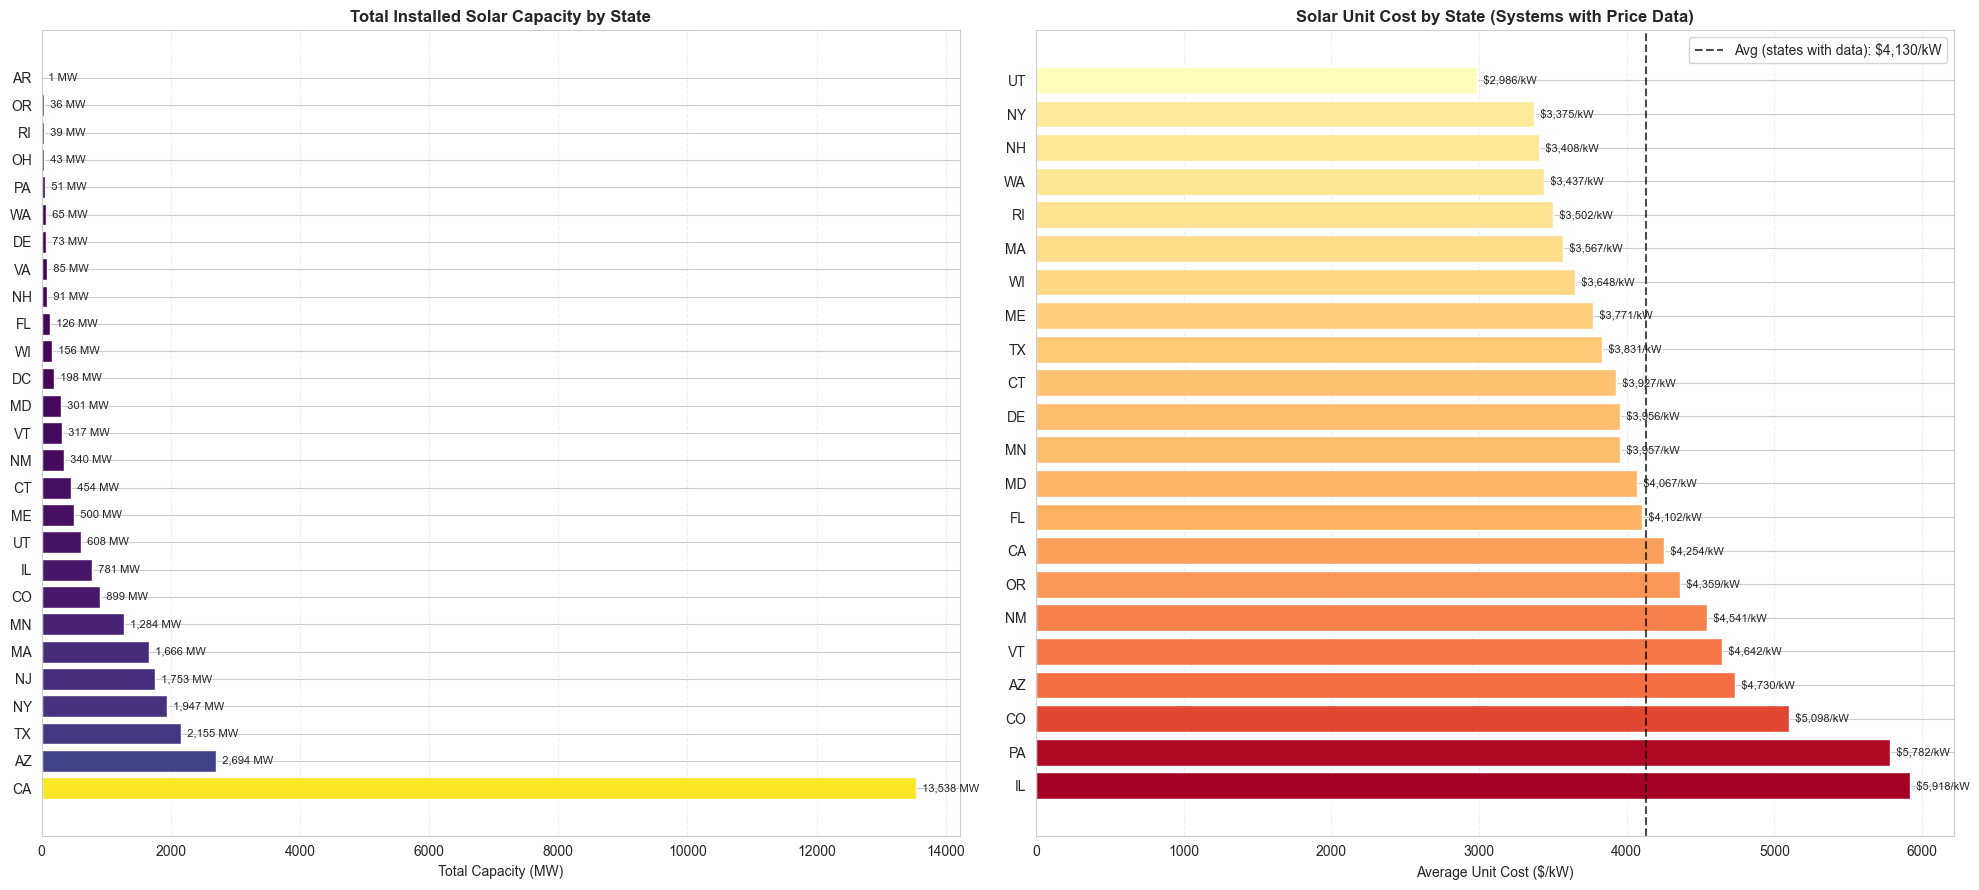

In [ ]:
# ---------- Aggregate data ----------

# Capacity by state (all installations with capacity data)
state_capacity = (
    tts_df.groupby('state')['PV_system_size_DC']
    .agg(total_capacity_kw='sum',
         num_installations='count',
         avg_system_size_kw='mean')
    .reset_index()
    .assign(total_capacity_mw=lambda x: x.total_capacity_kw / 1000)
    .sort_values('total_capacity_kw', ascending=False)
)

# ---------- Capacity-weighted unit cost by state ----------
print(f"\n📊 Cost Data Quality Check:")
print(f"  Total installations: {len(tts_df):,}")
print(f"  With price data: {tts_df['total_installed_price'].notna().sum():,}")
print(f"  With capacity data: {tts_df['PV_system_size_DC'].notna().sum():,}")

# Filter to installations with BOTH price and capacity
tts_with_cost = tts_df[
    tts_df['total_installed_price'].notna() & 
    tts_df['PV_system_size_DC'].notna() &
    (tts_df['total_installed_price'] > 0) &
    (tts_df['PV_system_size_DC'] > 0)
].copy()

print(f"  With BOTH price & capacity: {len(tts_with_cost):,} ({len(tts_with_cost)/len(tts_df)*100:.1f}%)")

# Now aggregate only these matched records
state_unit_cost = (
    tts_with_cost.groupby('state')
    .agg(
        total_cost=('total_installed_price', 'sum'),
        total_capacity_kw=('PV_system_size_DC', 'sum'),
        num_systems=('PV_system_size_DC', 'count')
    )
    .reset_index()
    .query('num_systems >= 100')  # Require at least 100 systems with cost data
)

state_unit_cost['avg_unit_cost_kw'] = (
    state_unit_cost['total_cost'] / state_unit_cost['total_capacity_kw']
)

# Additional validation: flag unrealistic unit costs
state_unit_cost = state_unit_cost[
    (state_unit_cost['avg_unit_cost_kw'] > 0) & 
    (state_unit_cost['avg_unit_cost_kw'] < 20000)  # Sanity check: < $20k/kW
].copy()

state_unit_cost = state_unit_cost.sort_values('avg_unit_cost_kw', ascending=False)

print(f"\n✓ States with valid cost data: {len(state_unit_cost)}")
print(f"  Cost range: ${state_unit_cost['avg_unit_cost_kw'].min():,.0f} - ${state_unit_cost['avg_unit_cost_kw'].max():,.0f}/kW")
print(f"  Median: ${state_unit_cost['avg_unit_cost_kw'].median():,.0f}/kW")

# ---------- Plot ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

# --- Plot 1: Total installed capacity (all systems) ---
colors1 = plt.cm.viridis(
    state_capacity.total_capacity_mw / state_capacity.total_capacity_mw.max()
)
ax1.barh(state_capacity.state, state_capacity.total_capacity_mw, color=colors1)
ax1.set_title('Total Installed Solar Capacity by State', fontweight='bold')
ax1.set_xlabel('Total Capacity (MW)')
ax1.grid(axis='x', alpha=0.3, linestyle='--')

for i, v in enumerate(state_capacity.total_capacity_mw):
    ax1.text(v, i, f'  {v:,.0f} MW', va='center', fontsize=8)

# --- Plot 2: Capacity-weighted unit cost (only systems with price data) ---
colors2 = plt.cm.RdYlGn_r(
    state_unit_cost.avg_unit_cost_kw / state_unit_cost.avg_unit_cost_kw.max()
)
ax2.barh(state_unit_cost.state, state_unit_cost.avg_unit_cost_kw, color=colors2)
ax2.set_title('Solar Unit Cost by State (Systems with Price Data)', fontweight='bold')
ax2.set_xlabel('Average Unit Cost ($/kW)')
ax2.grid(axis='x', alpha=0.3, linestyle='--')

national_avg = state_unit_cost.avg_unit_cost_kw.mean()
ax2.axvline(
    national_avg, color='black', linestyle='--', alpha=0.7,
    label=f'Avg (states with data): ${national_avg:,.0f}/kW'
)
ax2.legend()

for i, v in enumerate(state_unit_cost.avg_unit_cost_kw):
    ax2.text(v, i, f'  ${v:,.0f}/kW', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Load USPS ZIP to County crosswalk

Source is official website of the United States government: Office of Policy Development and Research (PD&R)

https://www.huduser.gov/portal/datasets/usps_crosswalk.html

In [25]:
def fetch_usps_zip_county_crosswalk(state_query='All', api_token=None):
    """
    Fetch USPS ZIP to County crosswalk from HUD API with address ratios
    
    The crosswalk includes ratio fields that indicate what share of addresses 
    in each ZIP code fall within each county:
    - res_ratio: Share of residential addresses (0-1)
    - bus_ratio: Share of business addresses (0-1)  
    - oth_ratio: Share of other addresses/PO boxes (0-1)
    - tot_ratio: Share of all addresses combined (0-1)
    
    For each ZIP code, ratios across all counties sum to 1.0
    
    Parameters:
    -----------
    state_query : str
        State code (e.g., 'VA', 'CA') or 'All' for all US states
    api_token : str
        HUD API token (Bearer token)
    
    Returns:
    --------
    DataFrame with columns:
        - zip_code: 5-digit ZIP code
        - county_fips: County FIPS code (5 digits: state FIPS + county FIPS)
        - res_ratio: Residential address ratio (0-1)
        - bus_ratio: Business address ratio (0-1)
        - oth_ratio: Other address ratio (0-1)
        - tot_ratio: Total address ratio (0-1)
        - city, state: City and state names
    """
    
    url = "https://www.huduser.gov/hudapi/public/usps"
    headers = {"Authorization": f"Bearer {api_token}"}
    
    print(f"Fetching USPS ZIP-County crosswalk...")
    print(f"  State: {state_query}")
    print(f"  Type: 2 (zip-county)")
    
    response = requests.get(
        url, 
        headers=headers, 
        params={'type': 2, 'query': state_query}
    )
    
    if response.status_code == 200:
        data = response.json()
        results = data['data']['results']
        df = pd.DataFrame(results)
        
        # Standardize column names
        df.columns = [col.lower() for col in df.columns]
        
        # Convert geoid (county FIPS) to integer and create standardized zip_code
        df['county_fips'] = df['geoid'].astype(int)
        df['zip_code'] = df['zip'].astype(str).str.zfill(5)
        
        # Ensure ratio columns are numeric
        ratio_cols = ['res_ratio', 'bus_ratio', 'oth_ratio', 'tot_ratio']
        for col in ratio_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        print(f"✓ Successfully loaded ZIP-County crosswalk with address ratios")
        print(f"  Records: {len(df):,}")
        print(f"  Unique ZIP codes: {df['zip_code'].nunique():,}")
        print(f"  Unique counties: {df['county_fips'].nunique()}")
        print(f"  Columns: {df.columns.tolist()}")
        
        # Verify ratios sum to 1 within ZIP codes
        if 'tot_ratio' in df.columns:
            zip_ratio_sums = df.groupby('zip_code')['tot_ratio'].sum()
            print(f"\n  Ratio validation (tot_ratio sums by ZIP):")
            print(f"    Mean: {zip_ratio_sums.mean():.4f}")
            print(f"    Min:  {zip_ratio_sums.min():.4f}")
            print(f"    Max:  {zip_ratio_sums.max():.4f}")
        
        return df
    else:
        print(f"✗ Error: {response.status_code}")
        print(f"  Response: {response.text[:200]}")
        return None


# Load API token from environment variable
hud_api_token = os.getenv('HUD_API_TOKEN')

if not hud_api_token:
    print("⚠ Warning: HUD_API_TOKEN not found in environment variables")
    print("  Please set HUD_API_TOKEN in .env file or environment")
else:
    # Fetch ZIP-County crosswalk for all US
    print("=" * 70)
    print("Load USPS ZIP to County crosswalk via HUD API")
    print("=" * 70)
    print()
    
    # Note: 'All' returns full US data (may take a moment)
    hud_zip_county_df = fetch_usps_zip_county_crosswalk(state_query='All', api_token=hud_api_token)
    
    if hud_zip_county_df is not None:
        print(f"\n  First 10 rows with ratios:")
        display_cols = ['zip_code', 'county_fips', 'city', 'state', 'res_ratio', 'tot_ratio']
        available_cols = [col for col in display_cols if col in hud_zip_county_df.columns]
        print(hud_zip_county_df[available_cols].head(10))
        
        # Show example of multi-county ZIP
        multi_county_example = hud_zip_county_df.groupby('zip_code').size()
        multi_county_zips = multi_county_example[multi_county_example > 1].head(1)
        if len(multi_county_zips) > 0:
            example_zip = multi_county_zips.index[0]
            print(f"\n  Example: ZIP {example_zip} spans multiple counties:")
            example_data = hud_zip_county_df[hud_zip_county_df['zip_code'] == example_zip]
            print(example_data[available_cols])

Load USPS ZIP to County crosswalk via HUD API

Fetching USPS ZIP-County crosswalk...
  State: All
  Type: 2 (zip-county)
✓ Successfully loaded ZIP-County crosswalk with address ratios
  Records: 54,574
  Unique ZIP codes: 39,493
  Unique counties: 3233
  Columns: ['zip', 'geoid', 'res_ratio', 'bus_ratio', 'oth_ratio', 'tot_ratio', 'city', 'state', 'county_fips', 'zip_code']

  Ratio validation (tot_ratio sums by ZIP):
    Mean: 1.0000
    Min:  1.0000
    Max:  1.0000

  First 10 rows with ratios:
  zip_code  county_fips        city state  res_ratio  tot_ratio
0    00501        36103  HOLTSVILLE    NY        0.0        1.0
1    00604        72005   AGUADILLA    PR        1.0        1.0
2    00605        72005   AGUADILLA    PR        1.0        1.0
3    00606        72093     MARICAO    PR        1.0        1.0
4    00610        72011      ANASCO    PR        1.0        1.0
5    00611        72141     ANGELES    PR        1.0        1.0
6    00613        72013     ARECIBO    PR        

In [26]:
# General statistics and data quality checks for ZIP-County crosswalk
print("\n" + "=" * 70)
print("ZIP-County Crosswalk Data Quality Assessment")
print("=" * 70)

if hud_zip_county_df is not None:
    print(f"\nDataset Overview:")
    print(f"  Shape: {hud_zip_county_df.shape}")
    print(f"  Records: {len(hud_zip_county_df):,}")
    print(f"  Columns: {hud_zip_county_df.shape[1]}")
    
    print(f"\n\nMissing Values Summary:")
    missing_counts = hud_zip_county_df.isnull().sum()
    missing_percent = (hud_zip_county_df.isnull().sum() / len(hud_zip_county_df) * 100).round(2)
    missing_df = pd.DataFrame({
        'Column': missing_counts.index,
        'Missing_Count': missing_counts.values,
        'Missing_Percent': missing_percent.values
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing_df) > 0:
        print(f"\n⚠️  ALERT: {len(missing_df)} columns have missing values:")
        print(missing_df.to_string(index=False))
        print(f"\n  Total missing values: {missing_counts.sum():,}")
    else:
        print("✓ No missing values detected!")
    
    print(f"\n\nRatio Statistics (should all be between 0 and 1):")
    ratio_cols = ['res_ratio', 'bus_ratio', 'oth_ratio', 'tot_ratio']
    available_ratios = [col for col in ratio_cols if col in hud_zip_county_df.columns]
    if available_ratios:
        print(hud_zip_county_df[available_ratios].describe())
    
    print(f"\n\nKey Fields Summary:")
    print(f"  Unique ZIP codes: {hud_zip_county_df['zip_code'].nunique():,}")
    print(f"  Unique counties: {hud_zip_county_df['county_fips'].nunique():,}")
    print(f"  Unique states: {hud_zip_county_df['state'].nunique()}")
    
    # Check for any anomalies in ratios
    if 'res_ratio' in hud_zip_county_df.columns:
        invalid_ratios = hud_zip_county_df[
            (hud_zip_county_df['res_ratio'] < 0) | (hud_zip_county_df['res_ratio'] > 1)
        ]
        if len(invalid_ratios) > 0:
            print(f"\n⚠️  WARNING: {len(invalid_ratios)} records with invalid res_ratio (not in 0-1 range)")
        else:
            print(f"\n✓ All res_ratio values are valid (between 0 and 1)")
    
    print(f"\n✓ Data quality check complete!")
else:
    print("✗ No crosswalk data available to analyze")


ZIP-County Crosswalk Data Quality Assessment

Dataset Overview:
  Shape: (54574, 10)
  Records: 54,574
  Columns: 10


Missing Values Summary:
✓ No missing values detected!


Ratio Statistics (should all be between 0 and 1):
          res_ratio     bus_ratio     oth_ratio     tot_ratio
count  54574.000000  54574.000000  54574.000000  54574.000000
mean       0.657053      0.662275      0.657346      0.723660
std        0.435523      0.446797      0.460008      0.405787
min        0.000000      0.000000      0.000000      0.000027
25%        0.078888      0.036364      0.000000      0.283004
50%        0.991064      1.000000      1.000000      1.000000
75%        1.000000      1.000000      1.000000      1.000000
max        1.000000      1.000000      1.000000      1.000000


Key Fields Summary:
  Unique ZIP codes: 39,493
  Unique counties: 3,233
  Unique states: 59

✓ All res_ratio values are valid (between 0 and 1)

✓ Data quality check complete!


In [28]:
# Diagnostic: Understand the zip-county mapping
print("\n" + "=" * 70)
print("Analyzing Row Expansion in Merge")
print("=" * 70)

# Check for ZIP codes that map to multiple counties
zip_county_counts = hud_zip_county_df.groupby('zip_code').size()

print(f"\nZIP codes in crosswalk: {len(zip_county_counts)}")
print(f"Average counties per ZIP: {zip_county_counts.mean():.2f}")
print(f"Max counties for single ZIP: {zip_county_counts.max()}")
print(f"ZIP codes mapping to >1 county: {(zip_county_counts > 1).sum()}")

print(f"\n📊 Distribution of counties per ZIP code:")
print(zip_county_counts.value_counts().sort_index().head(10))

print(f"\nExample: ZIP codes with multiple county mappings")
multi_county_zips = zip_county_counts[zip_county_counts > 1].head(3)
for zip_code in multi_county_zips.index:
    counties = hud_zip_county_df[hud_zip_county_df['zip_code'] == zip_code]['county_fips'].tolist()
    print(f"  {zip_code} → Counties: {counties}")

print(f"\n💡 EXPLANATION:")
print(f"  ZIP codes can span multiple counties (one-to-many relationship)")
print(f"\n⚠️  Next steps:")
print(f"  Aggregate PV Install data per County using residential weighted allocation by ZIP code ratios")


Analyzing Row Expansion in Merge

ZIP codes in crosswalk: 39493
Average counties per ZIP: 1.38
Max counties for single ZIP: 7
ZIP codes mapping to >1 county: 11371

📊 Distribution of counties per ZIP code:
1    28122
2     8285
3     2526
4      507
5       44
6        7
7        2
Name: count, dtype: int64

Example: ZIP codes with multiple county mappings
  00601 → Counties: [72001, 72081]
  00602 → Counties: [72003, 72117, 72005]
  00603 → Counties: [72005, 72071, 72099]

💡 EXPLANATION:
  ZIP codes can span multiple counties (one-to-many relationship)

⚠️  Next steps:
  Aggregate PV Install data per County using residential weighted allocation by ZIP code ratios


In [65]:
# Merge Tracking the Sun data with ZIP-County crosswalk (with address ratios)
print("\n" + "=" * 70)
print("Adding County Information to Tracking the Sun Data")
print("=" * 70)

if hud_zip_county_df is not None:
    # Standardize TTS zip codes to match crosswalk format
    tts_df_standardized = tts_df.copy()
    tts_df_standardized.columns = [col.lower().replace(' ', '_') for col in tts_df_standardized.columns]
    
    # Convert ZIP codes to 5-digit strings
    tts_df_standardized['zip_code_std'] = (
    tts_df_standardized['zip_code']
    .astype(str)
    .str.split('-').str[0]  # Extract part before hyphen
    .str.split('.').str[0]   # Remove any decimal points
    .str.strip()              # Remove whitespace
    .apply(lambda x: x if x.isdigit() else '0')  # Set non-numeric to '0'
    .str.zfill(5)             # Zero-fill to 5 digits
    )
    
    print(f"\nStandardized TTS ZIP codes")
    print(f"  Sample ZIP codes: {tts_df_standardized['zip_code_std'].head().tolist()}")
    
    # Merge on ZIP code, including ratio fields for weighted aggregation
    print(f"\nMerging TTS data with HUD ZIP-County crosswalk (including ratios)...")
    print(f"  TTS records: {len(tts_df_standardized):,}")
    print(f"  Crosswalk records: {len(hud_zip_county_df):,}")
    
    # Include ratio fields in the merge for weighted aggregation
    merge_cols = ['zip_code', 'county_fips', 'state', 'res_ratio', 'bus_ratio', 'oth_ratio', 'tot_ratio']
    available_merge_cols = [col for col in merge_cols if col in hud_zip_county_df.columns]
    
    tts_merged = tts_df_standardized.merge(
        hud_zip_county_df[available_merge_cols],
        left_on='zip_code_std',
        right_on='zip_code',
        how='left'
    )
    
    print(f"\n✓ Merge complete!")
    print(f"  Result shape: {tts_merged.shape}")
    print(f"  Records with county_fips: {tts_merged['county_fips'].notna().sum():,}")
    print(f"  Records missing county_fips: {tts_merged['county_fips'].isna().sum():,}")
    
    # Show sample with county information and ratios
    print(f"\nSample records with county FIPS and residential ratio:")
    sample_cols = ['zip_code_std', 'state_x', 'city', 'county_fips', 'res_ratio', 'tot_ratio', 'pv_system_size_dc']
    print(tts_merged[[col for col in sample_cols if col in tts_merged.columns]].head(10))
    
    # Show example of multi-county ZIP with ratios
    multi_county_zips = tts_merged.groupby('zip_code_std')['county_fips'].nunique()
    multi_county_zips = multi_county_zips[multi_county_zips > 1]
    if len(multi_county_zips) > 0:
        example_zip = multi_county_zips.index[0]
        print(f"\n  Example: ZIP {example_zip} spans multiple counties (with ratios):")
        example_data = tts_merged[tts_merged['zip_code_std'] == example_zip]
        example_cols = ['zip_code_std', 'county_fips', 'res_ratio', 'tot_ratio']
        print(example_data[[col for col in example_cols if col in example_data.columns]].head())
    
    print(f"\n✓ SUCCESS: County FIPS and address ratios added to {tts_merged['county_fips'].notna().sum():,} records")
    print(f"  → Ready for weighted aggregation to county level")
else:
    print("✗ HUD ZIP-County crosswalk not loaded. Please load it first.")


Adding County Information to Tracking the Sun Data

Standardized TTS ZIP codes
  Sample ZIP codes: ['75019', '76022', '75209', '75006', '75025']

Merging TTS data with HUD ZIP-County crosswalk (including ratios)...
  TTS records: 3,557,472
  Crosswalk records: 54,574

✓ Merge complete!
  Result shape: (4192019, 90)
  Records with county_fips: 3,984,848
  Records missing county_fips: 207,171

Sample records with county FIPS and residential ratio:
  zip_code_std state_x        city  county_fips  res_ratio  tot_ratio  \
0        75019      TX     Coppell      48113.0   0.981627   0.983601   
1        75019      TX     Coppell      48121.0   0.018373   0.016399   
2        76022      TX     Bedford      48439.0   1.000000   1.000000   
3        75209      TX      Dallas      48113.0   1.000000   1.000000   
4        75006      TX  Carrollton      48113.0   1.000000   1.000000   
5        75025      TX       Plano      48085.0   1.000000   1.000000   
6        76179      TX   Ft. Worth    

In [155]:
# Aggregate Tracking the Sun data by COUNTY FIPS with residential ratio weighting
"""
ZIP-level solar adoption data were aggregated to the county level using residential address-weighted 
ZIP–county crosswalks to account for ZIP codes spanning multiple counties.

ASSUMPTION: Solar installations are distributed proportionally to residential addresses.
res_ratio represents the share of residential addresses in each county portion of a ZIP code.
We assume installation distribution follows the same proportion as address distribution.
This is a standard areal weighting technique but introduces estimation uncertainty.
"""

print("\n" + "=" * 70)
print("Aggregating to County Level using Residential Ratio Weighting")
print("=" * 70)

# Use the merged data with county_fips and res_ratio
# Filter to records with valid county FIPS
tts_with_county = tts_merged[tts_merged['county_fips'].notna()].copy()

print(f"\nFiltering to records with county FIPS...")
print(f"  Records with county_fips: {len(tts_with_county):,}")

# Standardize column names
tts_with_county['county_fips'] = tts_with_county['county_fips'].astype(int)

# Use res_ratio for weighting (residential installations in residential areas)
# If res_ratio is missing, fall back to tot_ratio or 1.0
if 'res_ratio' in tts_with_county.columns:
    tts_with_county['weight'] = tts_with_county['res_ratio'].fillna(
        tts_with_county.get('tot_ratio', 1.0)
    ).fillna(1.0)
    weighting_method = "res_ratio (residential address ratio)"
elif 'tot_ratio' in tts_with_county.columns:
    tts_with_county['weight'] = tts_with_county['tot_ratio'].fillna(1.0)
    weighting_method = "tot_ratio (total address ratio)"
else:
    tts_with_county['weight'] = 1.0
    weighting_method = "unweighted (no ratio available)"

print(f"\nWeighting method: {weighting_method}")
print(f"  Weight statistics:")
print(f"    Mean weight: {tts_with_county['weight'].mean():.4f}")
print(f"    Min weight:  {tts_with_county['weight'].min():.4f}")
print(f"    Max weight:  {tts_with_county['weight'].max():.4f}")
print(f"    Records with weight < 1.0: {(tts_with_county['weight'] < 1.0).sum():,}")

# Create weighted capacity
tts_with_county['weighted_capacity'] = tts_with_county['pv_system_size_dc'] * tts_with_county['weight']
tts_with_county['weighted_price'] = tts_with_county['total_installed_price'] * tts_with_county['weight']
tts_with_county['weighted_count'] = tts_with_county['weight'] # Each installation weighted by res_ratio

# Aggregate by county_fips with weighted metrics
county_solar_df = tts_with_county.groupby('county_fips', as_index=False).agg({
    'weighted_count': 'sum',           # Sum of fractional installations per county
    'weighted_capacity': 'sum',         # Sum of weighted capacity
    'weighted_price': 'sum',            # Sum of weighted total installed price
    'pv_system_size_dc': ['median', 'mean', 'std']  # Unweighted statistics for reference
}).reset_index(drop=True)

# Flatten column names
county_solar_df.columns = ['county_fips', 'installation_count_weighted', 'total_capacity_kw_weighted', 
                            'total_price_weighted', 'median_size_kw', 'avg_size_kw', 'std_size_kw']

# Calculate weighted average system size
county_solar_df['avg_size_kw_weighted'] = (
    county_solar_df['total_capacity_kw_weighted'] / 
    county_solar_df['installation_count_weighted']
)

county_solar_df['avg_unit_cost_weighted'] = (
    county_solar_df['total_price_weighted'] / 
    county_solar_df['total_capacity_kw_weighted']
)

# IMPORTANT: Filter out counties with zero weighted installations
# These counties had installations but all in non-residential ZIP portions (res_ratio = 0)
# They create NaN values from 0/0 division and aren't relevant for residential solar modeling
counties_before = len(county_solar_df)
county_solar_df = county_solar_df[county_solar_df['installation_count_weighted'] > 0].copy()
counties_removed = counties_before - len(county_solar_df)

if counties_removed > 0:
    print(f"\n⚠️  Removed {counties_removed} counties with zero weighted installations")
    print(f"   (installations were in non-residential portions of ZIP codes)")

# Keep only essential columns for modeling
county_solar_df = county_solar_df[['county_fips', 'installation_count_weighted', 
                                     'total_capacity_kw_weighted', 'total_price_weighted',
                                     'avg_size_kw_weighted', 'avg_unit_cost_weighted']].copy()

print(f"\n✓ Aggregated to county level with residential ratio weighting!")
print(f"  Total unique counties: {len(county_solar_df)}")
print(f"  Total weighted installations: {county_solar_df['installation_count_weighted'].sum():,.1f}")
print(f"  Total weighted capacity (kW): {county_solar_df['total_capacity_kw_weighted'].sum():,.0f}")

# Check for missing values in aggregated data
print(f"\n📊 Missing Values Check:")
for col in county_solar_df.columns:
    missing = county_solar_df[col].isna().sum()
    if missing > 0:
        print(f"  ⚠️  {col}: {missing} missing ({missing/len(county_solar_df)*100:.1f}%)")
    else:
        print(f"  ✓ {col}: No missing values")

# Check for potential issues with avg_size_kw_weighted
if 'avg_size_kw_weighted' in county_solar_df.columns:
    inf_values = county_solar_df['avg_size_kw_weighted'].isin([np.inf, -np.inf]).sum()
    if inf_values > 0:
        print(f"\n  ⚠️  WARNING: {inf_values} counties have infinite avg_size_kw_weighted values")

print(f"\nTop 15 counties by weighted installation count:")
top_counties = county_solar_df.nlargest(15, 'installation_count_weighted')
print(top_counties[['county_fips', 'installation_count_weighted', 'total_capacity_kw_weighted', 'avg_size_kw_weighted']])

print(f"\n\nSummary Statistics (weighted):")
print(f"  Average installations per county: {county_solar_df['installation_count_weighted'].mean():.1f}")
print(f"  Median installations per county: {county_solar_df['installation_count_weighted'].median():.1f}")
print(f"  Average weighted system size: {county_solar_df['avg_size_kw_weighted'].mean():.2f} kW")

print(f"\n📊 Methodology:")
print(f"  ZIP-level solar adoption data were aggregated to the county level using")
print(f"  residential address-weighted ZIP–county crosswalks to account for ZIP")
print(f"  codes spanning multiple counties. Each installation was allocated to")
print(f"  counties proportionally based on the share of residential addresses in")
print(f"  that ZIP–county pair (res_ratio from HUD-USPS crosswalk).")
print(f"\n  Counties with zero residential installations (all installations in")
print(f"  non-residential ZIP portions) were excluded from the analysis.")


Aggregating to County Level using Residential Ratio Weighting

Filtering to records with county FIPS...
  Records with county_fips: 3,984,848

Weighting method: res_ratio (residential address ratio)
  Weight statistics:
    Mean weight: 0.8399
    Min weight:  0.0000
    Max weight:  1.0000
    Records with weight < 1.0: 1,168,613

⚠️  Removed 8 counties with zero weighted installations
   (installations were in non-residential portions of ZIP codes)

✓ Aggregated to county level with residential ratio weighting!
  Total unique counties: 1280
  Total weighted installations: 3,346,946.0
  Total weighted capacity (kW): 27,927,007

📊 Missing Values Check:
  ✓ county_fips: No missing values
  ✓ installation_count_weighted: No missing values
  ✓ total_capacity_kw_weighted: No missing values
  ✓ total_price_weighted: No missing values
  ✓ avg_size_kw_weighted: No missing values
  ✓ avg_unit_cost_weighted: No missing values

Top 15 counties by weighted installation count:
     county_fips  i

In [156]:
county_solar_df

,county_fips,installation_count_weighted,total_capacity_kw_weighted,total_price_weighted,avg_size_kw_weighted,avg_unit_cost_weighted
0,1073,1.000000,5.640000,4.978500e+04,5.640000,8827.127660
1,1083,0.743676,4.759524,3.498845e+04,6.400000,7351.250000
2,1089,0.256324,1.640476,1.205955e+04,6.400000,7351.250000
3,4001,70.996624,426.873585,6.041641e+06,6.012590,14153.232594
4,4003,2074.184600,13889.504581,4.269621e+07,6.696369,3073.990609
...,...,...,...,...,...,...
1283,72071,0.000864,0.006051,6.482982e+01,7.000000,10714.285714
1284,72099,0.000648,0.004538,4.862237e+01,7.000000,10714.285714
1285,72113,0.003928,0.027498,1.571313e+02,7.000000,5714.285714
1286,72141,0.996072,6.972502,3.984287e+04,7.000000,5714.285714


## 2. County-Level Average Daily Sunlight Data derived from NLDAS

NLDAS = North American Land Data Assimilation System

Contains county-level average daily sunlight values (insolation) in kilojoules per square meter (KJ/m²) for U.S. counties, derived from the North America Land Data Assimilation System (NLDAS).

Irradiance is the instantaneous power of sunlight hitting a surface (W/m²), while
insolation (daily sunlight) is the total energy received over a period of time (e.g., kWh/m²/day).

In [72]:
# Fetch County-Level Average Daily Sunlight from ArcGIS
print("=" * 70)
print("Fetch Average Daily Sunlight by County (ArcGIS)")
print("=" * 70)

import requests
import json

try:
    # ArcGIS REST API endpoint for Average Daily Sunlight
    url = "https://services.arcgis.com/dVL5xxth19juhrDY/arcgis/rest/services/Average_Daily_Sunlight/FeatureServer/0/query"
    
    # Parameters for REST query
    params = {
        'where': '1=1',  # Get all records
        'outFields': '*',  # Get all fields
        'returnGeometry': False,  # Don't need geometry for this
        'f': 'json',
        'resultRecordCount': 10000  # Fetch up to 10k records (there are ~3000 US counties)
    }
    
    print("\nFetching data from ArcGIS REST API...")
    print(f"Endpoint: {url}")
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    data = response.json()
    
    print(f"✓ Request successful!")
    print(f"  Status: {response.status_code}")
    print(f"  Records returned: {len(data.get('features', []))}")
    
    # Parse features into DataFrame
    if 'features' in data and len(data['features']) > 0:
        features = data['features']
        
        # Extract attributes from each feature
        records = []
        for feature in features:
            attr = feature['attributes']
            records.append(attr)
        
        sunlight_df = pd.DataFrame(records)
        
        print(f"\n✓ Parsed into DataFrame")
        print(f"  Shape: {sunlight_df.shape}")
        print(f"  Columns: {list(sunlight_df.columns)}")
        
        print(f"\nFirst 5 rows:")
        print(sunlight_df.head())
        
        print(f"\nData summary:")
        print(sunlight_df.describe())
        
        print(f"\n✓ SUCCESS: County-level sunlight data loaded!")
    else:
        print("No features found in response")
        print(f"Response: {data}")
        
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

Fetch Average Daily Sunlight by County (ArcGIS)

Fetching data from ArcGIS REST API...
Endpoint: https://services.arcgis.com/dVL5xxth19juhrDY/arcgis/rest/services/Average_Daily_Sunlight/FeatureServer/0/query
✓ Request successful!
  Status: 200
  Records returned: 2000

✓ Parsed into DataFrame
  Shape: (2000, 15)
  Columns: ['OBJECTID', 'NAME', 'STATE_NAME', 'STATE_ABBR', 'STATE_FIPS', 'COUNTY_FIPS', 'FIPS', 'POPULATION', 'POP_SQMI', 'SQMI', 'County', 'County_Code', 'Avg_Daily_Sunlight__KJ_m__', 'Shape__Area', 'Shape__Length']

First 5 rows:
   OBJECTID            NAME STATE_NAME STATE_ABBR STATE_FIPS COUNTY_FIPS  \
0         1  Autauga County    Alabama         AL         01         001   
1         2  Baldwin County    Alabama         AL         01         003   
2         3  Barbour County    Alabama         AL         01         005   
3         4     Bibb County    Alabama         AL         01         007   
4         5   Blount County    Alabama         AL         01         009 

In [73]:
# Clean and rename columns in sunlight_df for merging
print("\n" + "=" * 70)
print("Preparing Sunlight Data for Merge")
print("=" * 70)

# Determine which FIPS column to use
if 'FIPS' in sunlight_df.columns:
    fips_col = 'FIPS'
else:
    fips_col = None

if fips_col:
    # Standardize column names
    sunlight_df = sunlight_df.rename(columns={
        fips_col: 'county_fips',
        'Avg_Daily_Sunlight__KJ_m__': 'avg_daily_sunlight'
    })
    
    # Select only necessary columns for modeling
    essential_cols = ['county_fips', 'avg_daily_sunlight']
    
    if all(col in sunlight_df.columns for col in essential_cols):
        sunlight_df = sunlight_df[essential_cols].copy()
        
        # Ensure county_fips is integer
        sunlight_df['county_fips'] = sunlight_df['county_fips'].astype(int)
        
        print(f"\n✓ Sunlight data cleaned and ready for merge!")
        print(f"  Shape: {sunlight_df.shape}")
        print(f"  Columns: {list(sunlight_df.columns)}")
        
        unique_counties = sunlight_df['county_fips'].nunique()
        print(f"  Unique counties: {unique_counties:,}")
        
        print(f"\n  Sunlight statistics:")
        print(sunlight_df['avg_daily_sunlight'].describe())
        
        # Check for missing values
        print(f"\n  Missing values check:")
        missing_sunlight = sunlight_df['avg_daily_sunlight'].isna().sum()
        if missing_sunlight > 0:
            print(f"    ⚠️  WARNING: {missing_sunlight} counties ({missing_sunlight/len(sunlight_df)*100:.1f}%) have missing sunlight data")
            print(f"\n    Counties with missing sunlight:")
            missing_counties = sunlight_df[sunlight_df['avg_daily_sunlight'].isna()]['county_fips'].tolist()
            print(f"    FIPS codes: {missing_counties[:20]}")  # Show first 20
            if len(missing_counties) > 20:
                print(f"    ... and {len(missing_counties) - 20} more")
        else:
            print(f"    ✓ No missing values in avg_daily_sunlight")
        
        print(f"\n  Sample data:")
        print(sunlight_df.head(10))
    else:
        print(f"⚠️  Missing required columns after rename")
        print(f"  Available columns: {list(sunlight_df.columns)}")
else:
    print(f"⚠️  No FIPS column found in sunlight data")
    print(f"  Available columns: {list(sunlight_df.columns)}")


Preparing Sunlight Data for Merge

✓ Sunlight data cleaned and ready for merge!
  Shape: (2000, 2)
  Columns: ['county_fips', 'avg_daily_sunlight']
  Unique counties: 2,000

  Sunlight statistics:
count     1954.000000
mean     16064.122288
std       1459.653540
min      13130.090000
25%      14911.007500
50%      15897.790000
75%      17112.787500
max      20774.770000
Name: avg_daily_sunlight, dtype: float64

  Missing values check:
    ⚠️  WARNING: 46 counties (2.3%) have missing sunlight data

    Counties with missing sunlight:
    FIPS codes: [2013, 2016, 2020, 2050, 2060, 2063, 2066, 2068, 2070, 2090, 2100, 2105, 2110, 2122, 2130, 2150, 2158, 2164, 2170, 2180]
    ... and 26 more

  Sample data:
   county_fips  avg_daily_sunlight
0         1001            17103.72
1         1003            17660.59
2         1005            17315.13
3         1007            16904.87
4         1009            16393.63
5         1011            17296.02
6         1013            17323.69
7      

## 3. US Census / American Community Survey - Demographic Data

Socioeconomic and housing characteristics from the American Community Survey (ACS) 5-year estimates.

Rationale: ACS 5-year data provide stable, county-complete measures of long-run structural conditions (e.g., income, homeownership, urbanicity).

Assumption: These characteristics change slowly over time and reflect persistent adoption barriers rather than short-term shocks.

https://www.census.gov/data/developers/data-sets/acs-5year.html

In [121]:
import censusdis.data as ced
from censusdis.datasets import ACS5
from censusdis import states

# Download Census ACS demographic data for all US counties
# Variables documentation: https://api.census.gov/data/2023/acs/acs5/variables.html
census_df = ced.download(
    dataset=ACS5,
    vintage=2023,
    download_variables=[
        'NAME',           # County name
        
        # Income & affordability
        'B19013_001E',    # Median household income (dollars)
        
        # Housing characteristics
        'B25003_001E',    # Total occupied housing units
        'B25003_002E',    # Owner-occupied housing units
        'B25010_001E',    # Average household size
        
        # Housing structure type (for single-family home %)
        'B25024_001E',    # Total housing units (by structure type)
        'B25024_002E',    # 1-unit detached (single-family homes)
        'B25024_003E',    # 1-unit attached
        
        # Education (% with bachelor's degree or higher)
        'B15003_001E',    # Total population 25 years and over
        'B15003_022E',    # Bachelor's degree
        'B15003_023E',    # Master's degree
        'B15003_024E',    # Professional school degree
        'B15003_025E',    # Doctorate degree
        
        # Race and ethnicity composition
        'B03002_001E',    # Total population (for race/ethnicity)
        'B03002_003E',    # White alone, not Hispanic or Latino
        'B03002_004E',    # Black or African American alone
        'B03002_012E',    # Hispanic or Latino
        
        # Population
        'B01003_001E',    # Total population
    ],
    state='*',
    county='*'
)

# Calculate derived variables
# 1. Homeownership rate (%)
census_df['homeownership_rate'] = (
    census_df['B25003_002E'] / census_df['B25003_001E'] * 100
)

# 2. Single-family home percentage (%)
census_df['single_family_home_pct'] = (
    (census_df['B25024_002E'] + census_df['B25024_003E']) / census_df['B25024_001E'] * 100
)

# 3. Education: % with bachelor's degree or higher
census_df['pct_bachelors_or_higher'] = (
    (census_df['B15003_022E'] + census_df['B15003_023E'] + 
     census_df['B15003_024E'] + census_df['B15003_025E']) / 
    census_df['B15003_001E'] * 100
)

# 4. Race/ethnicity percentages
census_df['pct_white_non_hispanic'] = (census_df['B03002_003E'] / census_df['B03002_001E'] * 100)
census_df['pct_black'] = (census_df['B03002_004E'] / census_df['B03002_001E'] * 100)
census_df['pct_hispanic'] = (census_df['B03002_012E'] / census_df['B03002_001E'] * 100)

# Rename columns for clarity
census_df = census_df.rename(columns={
    'B19013_001E': 'median_household_income',
    'B01003_001E': 'total_population',
    'B25003_001E': 'total_occupied_housing_units',
    'B25003_002E': 'owner_occupied_housing_units',
    'B25010_001E': 'avg_household_size'
})

# Create county_fips from STATE and COUNTY columns (if they exist as index or columns)
# The censusdis package typically uses STATE and COUNTY as part of the index
if isinstance(census_df.index, pd.MultiIndex):
    # Extract STATE and COUNTY from MultiIndex
    census_df = census_df.reset_index()
    
if 'STATE' in census_df.columns and 'COUNTY' in census_df.columns:
    census_df['county_fips'] = (
        census_df['STATE'].astype(str).str.zfill(2) + 
        census_df['COUNTY'].astype(str).str.zfill(3)
    ).astype(int)

print("=" * 70)
print("Census ACS 2023 5-Year Estimates - County Demographics")
print("=" * 70)
print(f"\nShape: {census_df.shape}")
print(f"Counties: {len(census_df):,}")

print("\n📊 Variables loaded:")
print("  ✓ Financing/Affordability:")
print("    • Median household income")
print("  ✓ Structural Feasibility:")
print("    • Homeownership rate (%)")
print("    • Single-family home percentage (%)")
print("  ✓ Demographic Controls:")
print("    • Education (% bachelor's degree or higher)")
print("    • Race/ethnicity (% White non-Hispanic, % Black, % Hispanic)")
print("  ✓ Other:")
print("    • Total population")
print("    • Average household size")

print("\n✓ Sample data:")
display_cols = ['NAME', 'county_fips', 'median_household_income', 'homeownership_rate', 
                'single_family_home_pct', 'pct_bachelors_or_higher', 'total_population']
available_cols = [col for col in display_cols if col in census_df.columns]
print(census_df[available_cols].head(10))

Census ACS 2023 5-Year Estimates - County Demographics

Shape: (3222, 27)
Counties: 3,222

📊 Variables loaded:
  ✓ Financing/Affordability:
    • Median household income
  ✓ Structural Feasibility:
    • Homeownership rate (%)
    • Single-family home percentage (%)
  ✓ Demographic Controls:
    • Education (% bachelor's degree or higher)
    • Race/ethnicity (% White non-Hispanic, % Black, % Hispanic)
  ✓ Other:
    • Total population
    • Average household size

✓ Sample data:
                       NAME  county_fips  median_household_income  \
0   Autauga County, Alabama         1001                  69841.0   
1   Baldwin County, Alabama         1003                  75019.0   
2   Barbour County, Alabama         1005                  44290.0   
3      Bibb County, Alabama         1007                  51215.0   
4    Blount County, Alabama         1009                  61096.0   
5   Bullock County, Alabama         1011                  36723.0   
6    Butler County, Alabama     

### Add Urbanicity Classification

For urbanicity, we'll use population density as a proxy:
- **Urban**: > 1,000 people per square mile
- **Suburban**: 200-1,000 people per square mile  
- **Rural**: < 200 people per square mile

We'll need county land area data to calculate population density.

In [122]:
# Get county land area data from Census Gazetteer Files
# Source: https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.html

import io

print("=" * 70)
print("Fetching County Land Area Data from Census Gazetteer")
print("=" * 70)

try:
    # Census Gazetteer file for counties (2023)
    gazetteer_url = "https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2023_Gazetteer/2023_Gaz_counties_national.zip"
    
    print(f"\nDownloading from: {gazetteer_url}")
    
    # Download and read the zip file
    import zipfile
    response = requests.get(gazetteer_url)
    
    if response.status_code == 200:
        # Extract the txt file from zip
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # The file is typically named like '2023_gaz_counties_national.txt'
            txt_filename = [f for f in z.namelist() if f.endswith('.txt')][0]
            with z.open(txt_filename) as f:
                # Read as tab-delimited file
                area_df = pd.read_csv(f, sep='\t', encoding='latin1')
        
        print(f"✓ Successfully loaded county area data")
        print(f"  Records: {len(area_df):,}")
        print(f"  Columns: {list(area_df.columns)}")
        
        # Create county_fips from GEOID
        if 'GEOID' in area_df.columns:
            area_df['county_fips'] = area_df['GEOID'].astype(int)
        
        # Select relevant columns: county_fips, land area in sq miles
        # Column name is typically 'ALAND_SQMI' for land area in square miles
        area_cols = ['county_fips', 'NAME', 'ALAND_SQMI']
        available_area_cols = [col for col in area_cols if col in area_df.columns]
        
        area_df_subset = area_df[available_area_cols].copy()
        area_df_subset = area_df_subset.rename(columns={'ALAND_SQMI': 'land_area_sq_mi'})
        
        print(f"\n  Sample data:")
        print(area_df_subset.head())
        
        # Merge with census_df to add land area
        census_df_with_area = census_df.merge(
            area_df_subset[['county_fips', 'land_area_sq_mi']], 
            on='county_fips', 
            how='left'
        )
        
        # Calculate population density (people per square mile)
        census_df_with_area['population_density'] = (
            census_df_with_area['total_population'] / census_df_with_area['land_area_sq_mi']
        )
        
        # Create urbanicity categories
        def classify_urbanicity(density):
            if pd.isna(density):
                return 'Unknown'
            elif density >= 1000:
                return 'Urban'
            elif density >= 200:
                return 'Suburban'
            else:
                return 'Rural'
        
        census_df_with_area['urbanicity'] = census_df_with_area['population_density'].apply(classify_urbanicity)
        
        # Update the main census_df
        census_df = census_df_with_area
        
        print(f"\n✓ SUCCESS: Added population density and urbanicity classification!")
        print(f"\n  Urbanicity distribution:")
        print(census_df['urbanicity'].value_counts())
        
        print(f"\n  Population density statistics:")
        print(census_df['population_density'].describe())
        
    else:
        print(f"✗ Failed to download: Status {response.status_code}")
        
except Exception as e:
    print(f"✗ Error: {e}")
    import traceback
    traceback.print_exc()

Fetching County Land Area Data from Census Gazetteer

✓ Successfully loaded county area data
  Records: 3,222
  Columns: ['USPS', 'GEOID', 'ANSICODE', 'NAME', 'ALAND', 'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT', 'INTPTLONG                                                                                                               ']

  Sample data:
   county_fips            NAME  land_area_sq_mi
0         1001  Autauga County          594.455
1         1003  Baldwin County         1589.863
2         1005  Barbour County          885.008
3         1007     Bibb County          622.470
4         1009   Blount County          644.891

✓ SUCCESS: Added population density and urbanicity classification!

  Urbanicity distribution:
urbanicity
Rural       2593
Suburban     444
Urban        185
Name: count, dtype: int64

  Population density statistics:
count     3222.000000
mean       295.795473
std       1795.153655
min          0.035652
25%         16.963279
50%         46.573016
75%

In [123]:
# Display the census data
print("\n" + "=" * 70)
print("Census Data Summary")
print("=" * 70)

print("\nData types:")
print(census_df.dtypes)

print("\n\nSummary statistics:")
numeric_cols = ['median_household_income', 'homeownership_rate', 'total_population', 
                'avg_household_size', 'single_family_home_pct', 'pct_bachelors_or_higher',
                'pct_white_non_hispanic', 'pct_black', 'pct_hispanic']
available_numeric = [col for col in numeric_cols if col in census_df.columns]
if available_numeric:
    print(census_df[available_numeric].describe())

print("\n\nMissing values:")
missing = census_df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✓ No missing values")

census_df.head(15)


Census Data Summary

Data types:
STATE                            object
COUNTY                           object
NAME                             object
median_household_income         float64
total_occupied_housing_units      int64
owner_occupied_housing_units      int64
avg_household_size              float64
B25024_001E                       int64
B25024_002E                       int64
B25024_003E                       int64
B15003_001E                       int64
B15003_022E                       int64
B15003_023E                       int64
B15003_024E                       int64
B15003_025E                       int64
B03002_001E                       int64
B03002_003E                       int64
B03002_004E                       int64
B03002_012E                       int64
total_population                  int64
homeownership_rate              float64
single_family_home_pct          float64
pct_bachelors_or_higher         float64
pct_white_non_hispanic          float64
pct_bl

,STATE,COUNTY,NAME,median_household_income,total_occupied_housing_units,owner_occupied_housing_units,avg_household_size,B25024_001E,B25024_002E,B25024_003E,B15003_001E,B15003_022E,B15003_023E,B15003_024E,B15003_025E,B03002_001E,B03002_003E,B03002_004E,B03002_012E,total_population,homeownership_rate,single_family_home_pct,pct_bachelors_or_higher,pct_white_non_hispanic,pct_black,pct_hispanic,county_fips,land_area_sq_mi,population_density,urbanicity
0,01,001,"Autauga County, Alabama",69841.0,22523,16872,2.61,24731,18289,171,40767,6518,4006,599,407,59285,42497,11829,2188,59285,74.910092,74.643160,28.282680,71.682550,19.952771,3.690647,1001,594.455,99.730005,Rural
1,01,003,"Baldwin County, Alabama",75019.0,94642,73381,2.50,128518,83367,1929,171988,35348,14835,3843,2382,239945,195347,19051,13393,239945,77.535344,66.368913,32.797637,81.413241,7.939736,5.581696,1003,1589.863,150.921809,Rural
2,01,005,"Barbour County, Alabama",44290.0,9080,6128,2.39,11702,6806,82,17628,1179,559,193,90,24757,10807,11611,1490,24757,67.488987,58.861733,11.464715,43.652300,46.899867,6.018500,1005,885.008,27.973758,Rural
3,01,007,"Bibb County, Alabama",51215.0,7571,5843,2.74,9090,5425,60,15931,1121,537,92,77,22152,16333,4585,744,22152,77.176067,60.341034,11.468207,73.731492,20.697905,3.358613,1007,622.470,35.587257,Rural
4,01,009,"Blount County, Alabama",61096.0,21977,17473,2.67,24793,17350,186,40991,4088,1843,287,168,59292,50374,747,5962,59292,79.505847,70.729641,15.579030,84.959185,1.259866,10.055319,1009,644.891,91.941119,Rural
5,01,011,"Bullock County, Alabama",36723.0,3453,2193,2.64,4554,1939,3,7378,493,117,54,0,10157,2143,7234,577,10157,63.509991,42.643830,8.999729,21.098750,71.221817,5.680811,1011,622.815,16.308214,Rural
6,01,013,"Butler County, Alabama",44881.0,7262,4968,2.55,9841,6630,54,13164,1046,581,154,31,18807,9531,8411,300,18807,68.410906,67.919927,13.764813,50.677939,44.722710,1.595151,1013,776.839,24.209650,Rural
7,01,015,"Calhoun County, Alabama",55826.0,45125,31762,2.48,53271,38121,720,78627,9842,4500,955,857,116141,81098,25029,5150,116141,70.386704,72.912091,20.545105,69.827193,21.550529,4.434265,1015,605.890,191.686610,Rural
8,01,017,"Chambers County, Alabama",49295.0,13419,9526,2.52,16427,11500,46,24484,2386,921,174,90,34450,18575,13684,1270,34450,70.988896,70.286723,14.585035,53.918723,39.721335,3.686502,1017,596.554,57.748335,Rural
9,01,019,"Cherokee County, Alabama",50769.0,10477,8324,2.38,14663,10254,102,18777,1726,894,254,120,25224,22884,942,437,25224,79.450224,70.626748,15.945039,90.723121,3.734539,1.732477,1019,553.524,45.569840,Rural


In [124]:
# Deal with missing median_household_income values in ACS data
print("=" * 70)
print("Handling Missing Data in Census Demographics")
print("=" * 70)

# Identify missing values
missing_income = census_df[census_df['median_household_income'].isna()]

if len(missing_income) > 0:
    print(f"\n⚠️  Found {len(missing_income)} counties with missing median_household_income:")
    display_cols = ['NAME', 'county_fips', 'STATE', 'COUNTY', 'total_population']
    available_cols = [col for col in display_cols if col in missing_income.columns]
    print(missing_income[available_cols])
    
    # Strategy: Impute with state median income
    print(f"\n📊 Imputation Strategy:")
    print(f"  Fill missing values with state median household income")
    print(f"  This preserves state-level economic context")
    
    # Calculate state median income (excluding missing values)
    state_medians = census_df.groupby('STATE')['median_household_income'].median()
    
    print(f"\n  State median incomes being used:")
    missing_states = missing_income['STATE'].unique()
    for state in missing_states:
        if state in state_medians.index:
            print(f"    State {state}: ${state_medians[state]:,.0f}")
    
    # Fill missing values with state median
    def fill_income(row):
        if pd.isna(row['median_household_income']):
            return state_medians.get(row['STATE'], census_df['median_household_income'].median())
        return row['median_household_income']
    
    census_df['median_household_income'] = census_df.apply(fill_income, axis=1)
    
    # Verify no missing values remain
    remaining_missing = census_df['median_household_income'].isna().sum()
    
    if remaining_missing == 0:
        print(f"\n✓ SUCCESS: All missing values imputed!")
        print(f"  {len(missing_income)} counties filled with state median income")
    else:
        print(f"\n⚠️  WARNING: {remaining_missing} missing values remain")
        
else:
    print("\n✓ No missing values in median_household_income")

# Final check on all key demographic variables
print("\n" + "=" * 70)
print("Final Missing Values Check")
print("=" * 70)

key_vars = ['median_household_income', 'homeownership_rate', 'single_family_home_pct',
            'pct_bachelors_or_higher', 'pct_white_non_hispanic', 'pct_black', 'pct_hispanic',
            'total_population', 'population_density', 'urbanicity']
available_vars = [col for col in key_vars if col in census_df.columns]

missing_summary = census_df[available_vars].isnull().sum()
print(f"\nMissing values by variable:")
print(missing_summary)

if missing_summary.sum() == 0:
    print(f"\n✓ All key variables complete - no missing data!")
else:
    print(f"\n⚠️  Total missing values: {missing_summary.sum()}")

Handling Missing Data in Census Demographics

⚠️  Found 2 counties with missing median_household_income:
                          NAME  county_fips STATE COUNTY  total_population
1753  Esmeralda County, Nevada        32009    32    009               962
2655      Kenedy County, Texas        48261    48    261                52

📊 Imputation Strategy:
  Fill missing values with state median household income
  This preserves state-level economic context

  State median incomes being used:
    State 32: $73,364
    State 48: $63,367

✓ SUCCESS: All missing values imputed!
  2 counties filled with state median income

Final Missing Values Check

Missing values by variable:
median_household_income    0
homeownership_rate         0
single_family_home_pct     0
pct_bachelors_or_higher    0
pct_white_non_hispanic     0
pct_black                  0
pct_hispanic               0
total_population           0
population_density         0
urbanicity                 0
dtype: int64

✓ All key variabl

In [125]:
# Final census dataset with all demographic variables
print("\n" + "=" * 70)
print("Final Census Dataset - Ready for Merge")
print("=" * 70)

# Keep only essential columns for modeling
essential_census_cols = [
    'county_fips',                  # Merge key
    'NAME',                         # County code (for reference)
    'STATE',                        # State code (for reference)
    'median_household_income',      # Financing/Affordability
    'total_population',             # Population
    'homeownership_rate',           # Structural Feasibility
    'single_family_home_pct',       # Structural Feasibility
    'avg_household_size',           # Household characteristics
    'pct_bachelors_or_higher',      # Demographic Controls
    'pct_white_non_hispanic',       # Demographic Controls
    'pct_black',                    # Demographic Controls
    'pct_hispanic',                 # Demographic Controls
    'population_density',           # Geographic/Physical
    'urbanicity',                   # Geographic/Physical
]

# Select only available essential columns
available_essential = [col for col in essential_census_cols if col in census_df.columns]
census_df = census_df[available_essential].copy()

print(f"\nShape: {census_df.shape}")
print(f"Counties: {len(census_df):,}")

print("\n📊 Variables available:")
print("  ✓ Financing/Affordability:")
print("    • median_household_income")
print("  ✓ Structural Feasibility:")
print("    • homeownership_rate (%)")
print("    • single_family_home_pct (%)")
print("  ✓ Demographic Controls:")
print("    • pct_bachelors_or_higher (education)")
print("    • pct_white_non_hispanic")
print("    • pct_black")
print("    • pct_hispanic")
print("  ✓ Geographic/Physical:")
print("    • population_density (people/sq mi)")
print("    • urbanicity (Urban/Suburban/Rural)")
print("  ✓ Merge key:")
print("    • county_fips")

print("\n✓ Key statistics:")
key_vars = ['median_household_income', 'homeownership_rate', 'single_family_home_pct',
            'pct_bachelors_or_higher', 'population_density']
available_key = [col for col in key_vars if col in census_df.columns]
if available_key:
    print(census_df[available_key].describe())

print("\n✓ Sample records:")
display_cols = ['NAME', 'county_fips', 'median_household_income', 'homeownership_rate', 
                'single_family_home_pct', 'pct_bachelors_or_higher', 'urbanicity']
available_display = [col for col in display_cols if col in census_df.columns]
print(census_df[available_display].head(10))


Final Census Dataset - Ready for Merge

Shape: (3222, 14)
Counties: 3,222

📊 Variables available:
  ✓ Financing/Affordability:
    • median_household_income
  ✓ Structural Feasibility:
    • homeownership_rate (%)
    • single_family_home_pct (%)
  ✓ Demographic Controls:
    • pct_bachelors_or_higher (education)
    • pct_white_non_hispanic
    • pct_black
    • pct_hispanic
  ✓ Geographic/Physical:
    • population_density (people/sq mi)
    • urbanicity (Urban/Suburban/Rural)
  ✓ Merge key:
    • county_fips

✓ Key statistics:
       median_household_income  homeownership_rate  single_family_home_pct  \
count              3222.000000         3222.000000             3222.000000   
mean              65048.709187           72.938145               75.274399   
std               18383.581325            8.571038               10.005357   
min               16170.000000            0.000000                1.820297   
25%               54114.000000           68.731828               69.61285

## 4. DSIRE - Solar Policy Data
Binary policy indicators for net metering and incentive programs by state/county

Data download: https://www.dsireusa.org/resources/database-archives/

In [79]:
# Load DSIRE data from local CSV files
# Source: Database of State Incentives for Renewables & Efficiency (DSIRE)
# Data path: dsire-2025-11/

dsire_path = Path('source_datasets/dsire-2025-11')

print("=" * 70)
print("Loading DSIRE Policy Data")
print("=" * 70)

# List available CSV files
print("\nAvailable DSIRE files:")
csv_files = list(dsire_path.glob('*.csv'))
for f in sorted(csv_files):
    print(f"  • {f.name}")

print(f"\nTotal files: {len(csv_files)}")

# Load key tables
print("\n" + "=" * 70)
print("Loading Key Tables")
print("=" * 70)

# 1. Programs table (main table with all incentive programs)
programs_df = pd.read_csv(dsire_path / 'program.csv', low_memory=False)
print(f"\n✓ Programs: {len(programs_df):,} records, {programs_df.shape[1]} columns")

# 2. Program types (e.g., net metering, tax credit, rebate)
program_types_df = pd.read_csv(dsire_path / 'program_type.csv', low_memory=False)
print(f"✓ Program Types: {len(program_types_df):,} records")
print(f"  Available types: {program_types_df['name'].unique()[:10].tolist()}")

# 3. States table
states_df = pd.read_csv(dsire_path / 'state.csv', low_memory=False)
print(f"✓ States: {len(states_df):,} records")

# 4. Technologies (to filter for solar)
technologies_df = pd.read_csv(dsire_path / 'technology.csv', low_memory=False)
print(f"✓ Technologies: {len(technologies_df):,} records")

# 5. Program-Technology linkage
program_tech_df = pd.read_csv(dsire_path / 'program_technology.csv', low_memory=False)
print(f"✓ Program-Technology links: {len(program_tech_df):,} records")

# 6. Program categories
program_categories_df = pd.read_csv(dsire_path / 'program_category.csv', low_memory=False)
print(f"✓ Program Categories: {len(program_categories_df):,} records")

print("\n✓ SUCCESS: DSIRE data tables loaded!")

Loading DSIRE Policy Data

Available DSIRE files:
  • authority.csv
  • city.csv
  • contact.csv
  • county.csv
  • energy_category.csv
  • export.csv
  • implementing_sector.csv
  • parameter.csv
  • parameter_set.csv
  • parameter_set_sector.csv
  • parameter_set_technology.csv
  • program.csv
  • program_category.csv
  • program_city.csv
  • program_contact.csv
  • program_county.csv
  • program_detail.csv
  • program_detail_template.csv
  • program_sector.csv
  • program_technology.csv
  • program_type.csv
  • program_utility.csv
  • program_zipcode.csv
  • sector.csv
  • state.csv
  • state_info_content.csv
  • subscription_memo.csv
  • technology.csv
  • technology_category.csv
  • technology_info_content.csv
  • utility.csv
  • utility_zipcode.csv
  • zipcode.csv

Total files: 33

Loading Key Tables

✓ Programs: 5,649 records, 23 columns
✓ Program Types: 47 records
  Available types: ['Solar Access Law/Guideline', 'Green Building Incentive', 'Mandatory Utility Green Power Option

In [80]:
# Explore program data structure
print("=" * 70)
print("Exploring DSIRE Program Data Structure")
print("=" * 70)

print("\n1. Programs table columns:")
print(programs_df.columns.tolist())

print("\n2. Sample programs:")
display_cols = ['id', 'name', 'state_id', 'is_active', 'program_type_id']
available_cols = [col for col in display_cols if col in programs_df.columns]
print(programs_df[available_cols].head(10))

print("\n3. Program Types available:")
print(program_types_df[['id', 'name']].head(20))

print("\n4. Technologies (filtering for solar):")
solar_techs = technologies_df[technologies_df['name'].str.contains('Solar|Photovoltaic|PV', case=False, na=False)]
print(solar_techs[['id', 'name']])

print("\n5. Program Categories:")
print(program_categories_df.head())

print("\n6. States table structure:")
print(states_df.columns.tolist())
print("\nSample states:")
print(states_df[['id', 'name', 'code']].head(10) if 'code' in states_df.columns else states_df.head(10))

Exploring DSIRE Program Data Structure

1. Programs table columns:
['id', 'state_id', 'is_entire_state', 'implementing_sector_id', 'program_category_id', 'program_type_id', 'created_by_user_id', 'code', 'name', 'updated_ts', 'created_ts', 'published', 'websiteurl', 'administrator', 'fundingsource', 'budget', 'start_date', 'start_date_text', 'end_date', 'end_date_text', 'summary', 'additional_technologies', 'fromSir']

2. Sample programs:
   id                                               name  state_id  \
0   1         North Dakota Solar/Wind Easements and Laws        39   
1   2                    Qualifying Wood Stove Deduction         4   
2   3             Maryland Solar Easements & Rights Laws        24   
3   4  Oregon Solar and Wind Easements/Rights Laws & ...        42   
4   6                             Alaska Solar Easements         2   
5   7                Idaho Solar Easements & Access Laws        16   
6   8                         Kansas Solar Easement Laws        20  

In [81]:
# Filter for solar programs and create policy indicators
print("=" * 70)
print("Creating Solar Policy Indicators by State")
print("=" * 70)

# Step 1: Identify solar technologies
solar_tech_ids = technologies_df[
    technologies_df['name'].str.contains('Solar|Photovoltaic|PV', case=False, na=False)
]['id'].unique()

print(f"\n1. Solar technology IDs identified: {len(solar_tech_ids)}")
print(f"   IDs: {solar_tech_ids.tolist()}")

# Step 2: Filter programs linked to solar technologies
solar_programs = program_tech_df[program_tech_df['technology_id'].isin(solar_tech_ids)]
solar_program_ids = solar_programs['program_id'].unique()

print(f"\n2. Solar programs found: {len(solar_program_ids):,}")

# Step 3: Get details of solar programs
solar_programs_detail = programs_df[programs_df['id'].isin(solar_program_ids)].copy()

# Filter for active programs only
if 'is_active' in solar_programs_detail.columns:
    solar_programs_detail = solar_programs_detail[solar_programs_detail['is_active'] == True]
    print(f"   Active solar programs: {len(solar_programs_detail):,}")

print(f"\n3. Solar programs by state:")
if 'state_id' in solar_programs_detail.columns:
    state_counts = solar_programs_detail['state_id'].value_counts()
    print(f"   States with solar programs: {len(state_counts)}")

# Step 4: Identify specific policy types
# Net metering
net_metering_types = program_types_df[
    program_types_df['name'].str.contains('Net Metering|Net Energy Metering', case=False, na=False)
]
print(f"\n4. Policy Type Identification:")
print(f"   Net Metering type IDs: {net_metering_types['id'].tolist()}")
print(f"   Net Metering names: {net_metering_types['name'].tolist()}")

# Incentive types (tax credits, rebates, grants)
incentive_keywords = 'Tax Credit|Rebate|Grant|Incentive|Loan|Performance|Production Incentive'
incentive_types = program_types_df[
    program_types_df['name'].str.contains(incentive_keywords, case=False, na=False)
]
print(f"\n   Incentive program type IDs: {incentive_types['id'].tolist()[:10]}")
print(f"   Incentive types: {incentive_types['name'].tolist()[:10]}")

# Step 5: Create binary indicators by state
# Join programs with types
solar_programs_detail = solar_programs_detail.merge(
    program_types_df[['id', 'name']].rename(columns={'id': 'program_type_id', 'name': 'program_type_name'}),
    on='program_type_id',
    how='left'
)

# Create binary indicators
state_policy_df = solar_programs_detail.groupby('state_id').agg({
    'id': 'count',  # Total solar programs
}).reset_index()
state_policy_df.columns = ['state_id', 'total_solar_programs']

# Net metering indicator
net_metering_states = solar_programs_detail[
    solar_programs_detail['program_type_id'].isin(net_metering_types['id'])
]['state_id'].unique()

state_policy_df['has_net_metering'] = state_policy_df['state_id'].isin(net_metering_states).astype(int)

# Solar incentive indicator (any tax credit, rebate, grant, etc.)
incentive_states = solar_programs_detail[
    solar_programs_detail['program_type_id'].isin(incentive_types['id'])
]['state_id'].unique()

state_policy_df['has_solar_incentive'] = state_policy_df['state_id'].isin(incentive_states).astype(int)

# Merge with state information - check which columns are available
print(f"\n📋 States table columns: {states_df.columns.tolist()}")

# Build merge columns dynamically based on what's available
state_merge_cols = ['id', 'name']
state_rename = {'id': 'state_id', 'name': 'state_name'}

# Check for state code column (could be 'code', 'abbreviation', 'abbr', etc.)
for possible_code_col in ['code', 'abbreviation', 'abbr', 'state_code']:
    if possible_code_col in states_df.columns:
        state_merge_cols.append(possible_code_col)
        state_rename[possible_code_col] = 'code'
        break

state_policy_df = state_policy_df.merge(
    states_df[state_merge_cols].rename(columns=state_rename),
    on='state_id',
    how='left'
)

print(f"\n5. State Policy Summary:")
print(f"   Total states: {len(state_policy_df)}")
print(f"   States with net metering: {state_policy_df['has_net_metering'].sum()}")
print(f"   States with solar incentives: {state_policy_df['has_solar_incentive'].sum()}")

print("\n✓ Sample state policies:")
display_cols = ['state_name', 'has_net_metering', 'has_solar_incentive', 'total_solar_programs']
if 'code' in state_policy_df.columns:
    display_cols.insert(1, 'code')
print(state_policy_df[display_cols].head(15))

Creating Solar Policy Indicators by State

1. Solar technology IDs identified: 7
   IDs: [1, 2, 3, 5, 6, 7, 24]

2. Solar programs found: 2,091

3. Solar programs by state:
   States with solar programs: 59

4. Policy Type Identification:
   Net Metering type IDs: [37]
   Net Metering names: ['Net Metering']

   Incentive program type IDs: [10, 13, 18, 31, 68, 78, 81, 87, 88, 89]
   Incentive types: ['Green Building Incentive', 'Performance-Based Incentive', 'Corporate Tax Credit', 'Personal Tax Credit', 'Other Incentive', 'Property Tax Incentive', 'Sales Tax Incentive', 'Grant Program', 'Rebate Program', 'Loan Program']

📋 States table columns: ['id', 'abbreviation', 'name', 'is_territory']

5. State Policy Summary:
   Total states: 59
   States with net metering: 54
   States with solar incentives: 55

✓ Sample state policies:
              state_name code  has_net_metering  has_solar_incentive  \
0                Alabama   AL                 0                    1   
1              

In [82]:
# Create state name to FIPS mapping from Census data (authoritative source)
print("=" * 70)
print("Building State Name to FIPS Mapping (From Census Data)")
print("=" * 70)

# The Census data is our authoritative source for FIPS codes
# Extract unique state FIPS and names from census data
if 'STATE' in census_df.columns:
    # Get state FIPS and full names from census
    state_info = census_df[['STATE', 'NAME']].copy()
    state_info = state_info.drop_duplicates(subset=['STATE'])
    state_info['STATE'] = state_info['STATE'].astype(int)
    
    # Extract state name from "County, State" format
    state_info['state_full_name'] = state_info['NAME'].str.split(',').str[-1].str.strip()
    
    # Create state full name to FIPS mapping
    state_name_to_fips = dict(zip(state_info['state_full_name'], state_info['STATE']))
    
    print(f"\n✓ Created mapping from {len(state_name_to_fips)} state names to FIPS codes")
    print(f"\n  Sample mappings (from Census data):")
    for state_name, fips in list(state_name_to_fips.items())[:10]:
        print(f"    {state_name:20s} → FIPS {fips:02d}")
    
    # Now map DSIRE state names to FIPS codes using fuzzy matching
    print(f"\n📊 Mapping DSIRE states to Census FIPS codes...")
    
    # Try exact match first
    state_policy_df['state_fips'] = state_policy_df['state_name'].map(state_name_to_fips)
    
    # Check for unmapped states
    unmapped = state_policy_df[state_policy_df['state_fips'].isna()]
    
    if len(unmapped) > 0:
        print(f"\n⚠️  {len(unmapped)} DSIRE states need manual matching:")
        print(unmapped[['state_name']].values.tolist())
        print(f"\n  Available Census state names: {sorted(state_name_to_fips.keys())[:15]}")
    else:
        print(f"\n✓ All {len(state_policy_df)} DSIRE states successfully mapped to Census FIPS codes!")
        
                
else:
    print("⚠️  STATE column not available in census_df - cannot validate")

# Create final policy dataset for merging
dsire_policy_df = state_policy_df[['state_fips', 'state_name', 'code', 
                                     'has_net_metering', 'has_solar_incentive', 
                                     'total_solar_programs']].copy()

# Remove any rows without FIPS codes
dsire_policy_df = dsire_policy_df.dropna(subset=['state_fips'])
dsire_policy_df['state_fips'] = dsire_policy_df['state_fips'].astype(int)

print(f"\n✓ Final DSIRE Policy Dataset:")
print(f"   States: {len(dsire_policy_df)}")
print(f"   Variables:")
print(f"     • state_fips (merge key)")
print(f"     • has_net_metering (binary: 0/1)")
print(f"     • has_solar_incentive (binary: 0/1)")
print(f"     • total_solar_programs (count)")

print(f"\n📊 Policy Coverage Summary:")
print(f"   States with net metering: {dsire_policy_df['has_net_metering'].sum()} ({dsire_policy_df['has_net_metering'].sum()/len(dsire_policy_df)*100:.1f}%)")
print(f"   States with solar incentives: {dsire_policy_df['has_solar_incentive'].sum()} ({dsire_policy_df['has_solar_incentive'].sum()/len(dsire_policy_df)*100:.1f}%)")
print(f"   Average solar programs per state: {dsire_policy_df['total_solar_programs'].mean():.1f}")

print(f"\n✓ Sample data:")
print(dsire_policy_df.head(10))

print(f"\n✓ SUCCESS: DSIRE policy indicators ready for county-level merge!")
print(f"   → Counties will inherit state-level policies via state_fips mapping")

Building State Name to FIPS Mapping (From Census Data)

✓ Created mapping from 52 state names to FIPS codes

  Sample mappings (from Census data):
    Alabama              → FIPS 01
    Alaska               → FIPS 02
    Arizona              → FIPS 04
    Arkansas             → FIPS 05
    California           → FIPS 06
    Colorado             → FIPS 08
    Connecticut          → FIPS 09
    Delaware             → FIPS 10
    District of Columbia → FIPS 11
    Florida              → FIPS 12

📊 Mapping DSIRE states to Census FIPS codes...

⚠️  7 DSIRE states need manual matching:
[['American Samoa'], ['Federal'], ['Guam'], ['N. Mariana Islands'], ['Palau'], ['Virgin Islands'], ['Federated States of Micronesia']]

  Available Census state names: ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana']

✓ Final DSIRE Policy Dataset:
   States: 52
   Variables:


## Data Integration
Merge all datasets on county FIPS code for analysis

In [179]:
def merge_all_datasets(tracking_the_sun_df, sunlight_df, census_df, dsire_df):
    """
    Merge all four datasets on county FIPS code
    
    Parameters:
    -----------
    tracking_the_sun_df : DataFrame with solar installation data from LBNL Tracking the Sun
    sunlight_df : DataFrame with solar resource data
    census_df : DataFrame with demographic data
    dsire_df : DataFrame with policy data
    
    Returns:
    --------
    merged_df : Integrated dataset ready for analysis
    """
    
    # Start with Tracking the Sun data (outcome variable)
    merged = tracking_the_sun_df.copy()
    
    # Merge solar resource data
    if sunlight_df is not None:
        merged = merged.merge(sunlight_df, on='county_fips', how='left', suffixes=('', '_sunlight'))
    
    # Merge census demographic data
    if census_df is not None:
        merged = merged.merge(census_df, on='county_fips', how='left', suffixes=('', '_census'))
    
    # Merge policy data (state-level, so map to all counties in state)
    if dsire_df is not None:
        # Extract state FIPS from county FIPS (first 2 digits)
        merged['state_fips'] = merged['county_fips'] // 1000
        merged = merged.merge(dsire_df, on='state_fips', how='left', suffixes=('', '_policy'))
    
    print(f"Merged dataset shape: {merged.shape}")
    print(f"\nColumns: {list(merged.columns)}")
    
    return merged

# Integration function defined
print("Data integration function defined")

Data integration function defined


In [180]:
# Execute data integration
print("=" * 70)
print("Merging All Datasets on County FIPS")
print("=" * 70)

# Prepare inputs
print("\nInput datasets:")
print(f"  1. Tracking the Sun (county_solar_df): {county_solar_df.shape}")
print(f"  2. Sunlight data (sunlight_df): {sunlight_df.shape}")
print(f"  3. Census demographics (census_df): {census_df.shape}")
print(f"  4. DSIRE policies (dsire_policy_df): {dsire_policy_df.shape}")

# Execute merge
merged_df = merge_all_datasets(
    tracking_the_sun_df=county_solar_df,
    sunlight_df=sunlight_df,
    census_df=census_df,
    dsire_df=dsire_policy_df
)

print("\n" + "=" * 70)
print("Merge Results")
print("=" * 70)

print(f"\n✓ Merged dataset created!")

Merging All Datasets on County FIPS

Input datasets:
  1. Tracking the Sun (county_solar_df): (1280, 6)
  2. Sunlight data (sunlight_df): (2000, 2)
  3. Census demographics (census_df): (3222, 14)
  4. DSIRE policies (dsire_policy_df): (52, 6)
Merged dataset shape: (1280, 26)

Columns: ['county_fips', 'installation_count_weighted', 'total_capacity_kw_weighted', 'total_price_weighted', 'avg_size_kw_weighted', 'avg_unit_cost_weighted', 'avg_daily_sunlight', 'NAME', 'STATE', 'median_household_income', 'total_population', 'homeownership_rate', 'single_family_home_pct', 'avg_household_size', 'pct_bachelors_or_higher', 'pct_white_non_hispanic', 'pct_black', 'pct_hispanic', 'population_density', 'urbanicity', 'state_fips', 'state_name', 'code', 'has_net_metering', 'has_solar_incentive', 'total_solar_programs']

Merge Results

✓ Merged dataset created!


In [181]:
# Merged dataset overview
print("=" * 70)
print("Merged Dataset Overview")
print("=" * 70)

print(f"\n📊 Basic Info:")
print(f"  Total records: {len(merged_df):,}")
print(f"  Total columns: {merged_df.shape[1]}")
print(f"  Memory usage: {merged_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n📋 Missing Values Summary:")
missing_counts = merged_df.isnull().sum()
missing_pct = (missing_counts / len(merged_df) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_pct.values
})

# Only show columns with missing values
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(f"\n⚠️  Found {len(missing_df)} columns with missing values:")
    print(missing_df.to_string(index=False))
    print(f"\n  Total missing values: {missing_counts.sum():,}")
    print(f"  Columns with >50% missing: {len(missing_df[missing_df['Missing_Percent'] > 50])}")
else:
    print("\n✓ No missing values detected!")

# Check merge quality
print(f"\n📊 Merge Quality Assessment:")

# 1. Sunlight data coverage
if 'avg_daily_sunlight' in merged_df.columns:
    sunlight_coverage = merged_df['avg_daily_sunlight'].notna().sum()
    sunlight_missing = merged_df['avg_daily_sunlight'].isna().sum()
    print(f"  Sunlight data: {sunlight_coverage:,}/{len(merged_df):,} counties ({sunlight_coverage/len(merged_df)*100:.1f}%)")
    if sunlight_missing > 0:
        print(f"    ⚠️  {sunlight_missing} counties missing sunlight data")
        # Show which counties are missing sunlight data
        missing_sunlight_counties = merged_df[merged_df['avg_daily_sunlight'].isna()]['county_fips'].tolist()
        print(f"    Missing county FIPS: {missing_sunlight_counties[:10]}")
        if len(missing_sunlight_counties) > 10:
            print(f"    ... and {len(missing_sunlight_counties) - 10} more")

# 2. Census data coverage
if 'median_household_income' in merged_df.columns:
    census_coverage = merged_df['median_household_income'].notna().sum()
    census_missing = merged_df['median_household_income'].isna().sum()
    print(f"  Census data: {census_coverage:,}/{len(merged_df):,} counties ({census_coverage/len(merged_df)*100:.1f}%)")
    if census_missing > 0:
        print(f"    ⚠️  {census_missing} counties missing census data")
        missing_census_counties = merged_df[merged_df['median_household_income'].isna()]['county_fips'].tolist()
        print(f"    Missing county FIPS: {missing_census_counties}")

# 3. Policy data coverage (state-level, should cover all)
if 'has_net_metering' in merged_df.columns:
    policy_coverage = merged_df['has_net_metering'].notna().sum()
    policy_missing = merged_df['has_net_metering'].isna().sum()
    print(f"  Policy data: {policy_coverage:,}/{len(merged_df):,} counties ({policy_coverage/len(merged_df)*100:.1f}%)")
    if policy_missing > 0:
        print(f"    ⚠️  {policy_missing} counties missing policy data")
        missing_policy_counties = merged_df[merged_df['has_net_metering'].isna()]['county_fips'].tolist()
        print(f"    Missing county FIPS: {missing_policy_counties}")
    print(f"    Note: Policy data is state-level, applied to all counties in each state")


# 4. States represented
if 'state_fips' in merged_df.columns:
    unique_states = merged_df['state_fips'].nunique()
    print(f"  States represented: {unique_states}")
    
print(f"\n📊 Data Types:")
print(merged_df.dtypes.value_counts())

print(f"\n✓ Sample data:")
print(merged_df.head())

Merged Dataset Overview

📊 Basic Info:
  Total records: 1,280
  Total columns: 26
  Memory usage: 0.55 MB

📋 Missing Values Summary:

⚠️  Found 19 columns with missing values:
                 Column  Missing_Count  Missing_Percent
     avg_daily_sunlight            648            50.62
              pct_black              1             0.08
    has_solar_incentive              1             0.08
       has_net_metering              1             0.08
                   code              1             0.08
             state_name              1             0.08
             urbanicity              1             0.08
     population_density              1             0.08
           pct_hispanic              1             0.08
 pct_white_non_hispanic              1             0.08
                   NAME              1             0.08
pct_bachelors_or_higher              1             0.08
     avg_household_size              1             0.08
 single_family_home_pct              1  

In [182]:
# Drop St. John Island (county_fips 78020) - missing census and policy data
print("=" * 70)
print("Removing County with Missing Data")
print("=" * 70)

# Check if county exists
if 78020 in merged_df['county_fips'].values:
    print(f"\nFound county_fips 78020 (St. John Island)")
    
    # Show the record before removal
    st_john = merged_df[merged_df['county_fips'] == 78020]
    print(f"\nRecord details:")
    print(st_john[['county_fips', 'NAME', 'installation_count_weighted', 
                   'median_household_income', 'has_net_metering']].to_string())
    
    # Remove the row
    merged_df = merged_df[merged_df['county_fips'] != 78020].copy()
    
    print(f"\n✓ Removed county_fips 78020 (St. John Island)")
    print(f"  Remaining counties: {len(merged_df):,}")
else:
    print(f"\n✓ County_fips 78020 not found in dataset")

# Verify removal
remaining_missing_census = merged_df['median_household_income'].isna().sum()
remaining_missing_policy = merged_df['has_net_metering'].isna().sum()

print(f"\n📊 Missing Data Check After Removal:")
print(f"  Census data (median_household_income): {remaining_missing_census} missing")
print(f"  Policy data (has_net_metering): {remaining_missing_policy} missing")

if remaining_missing_census == 0 and remaining_missing_policy == 0:
    print(f"\n✓ SUCCESS: All counties now have complete census and policy data!")

Removing County with Missing Data

Found county_fips 78020 (St. John Island)

Record details:
      county_fips NAME  installation_count_weighted  median_household_income  has_net_metering
1279        78020  NaN                          1.0                      NaN               NaN

✓ Removed county_fips 78020 (St. John Island)
  Remaining counties: 1,279

📊 Missing Data Check After Removal:
  Census data (median_household_income): 0 missing
  Policy data (has_net_metering): 0 missing

✓ SUCCESS: All counties now have complete census and policy data!


In [183]:
# Create target variable: Residential adoption rate (per 1,000 population)
print("=" * 70)
print("Creating Target Variable: Residential Adoption Rate (per 1,000 population)")
print("=" * 70)    


# Use POPULATION as denominator, normalizes by County size to remoce scale effects
merged_df['adoption_rate_per_1k_pop'] = (
    merged_df['installation_count_weighted'] / 
    merged_df['total_population'] * 1000
)

# Log-transform
merged_df['log_adoption_rate_pop'] = np.log(merged_df['adoption_rate_per_1k_pop'] + 0.01)



Creating Target Variable: Residential Adoption Rate (per 1,000 population)


Solar Adoption Rates by State

📊 Top 20 States by Adoption Rate (per 1,000 population):
          state_name  state_adoption_rate_per_1k  total_installations  total_capacity_kw  num_counties
          California                   50.903574            1997598.0       1.349409e+07            58
             Arizona                   42.447657             308517.0       2.688443e+06            15
             Vermont                   40.824234              26342.0       2.896995e+05            14
District of Columbia                   24.718820              16613.0       1.699902e+05             1
          New Mexico                   24.321344              51434.0       3.374928e+05            33
          New Jersey                   21.491497             199162.0       1.747584e+06            21
       Massachusetts                   19.520922             136498.0       1.656160e+06            14
            Colorado                   19.073991             105212.0       8.900340e+05

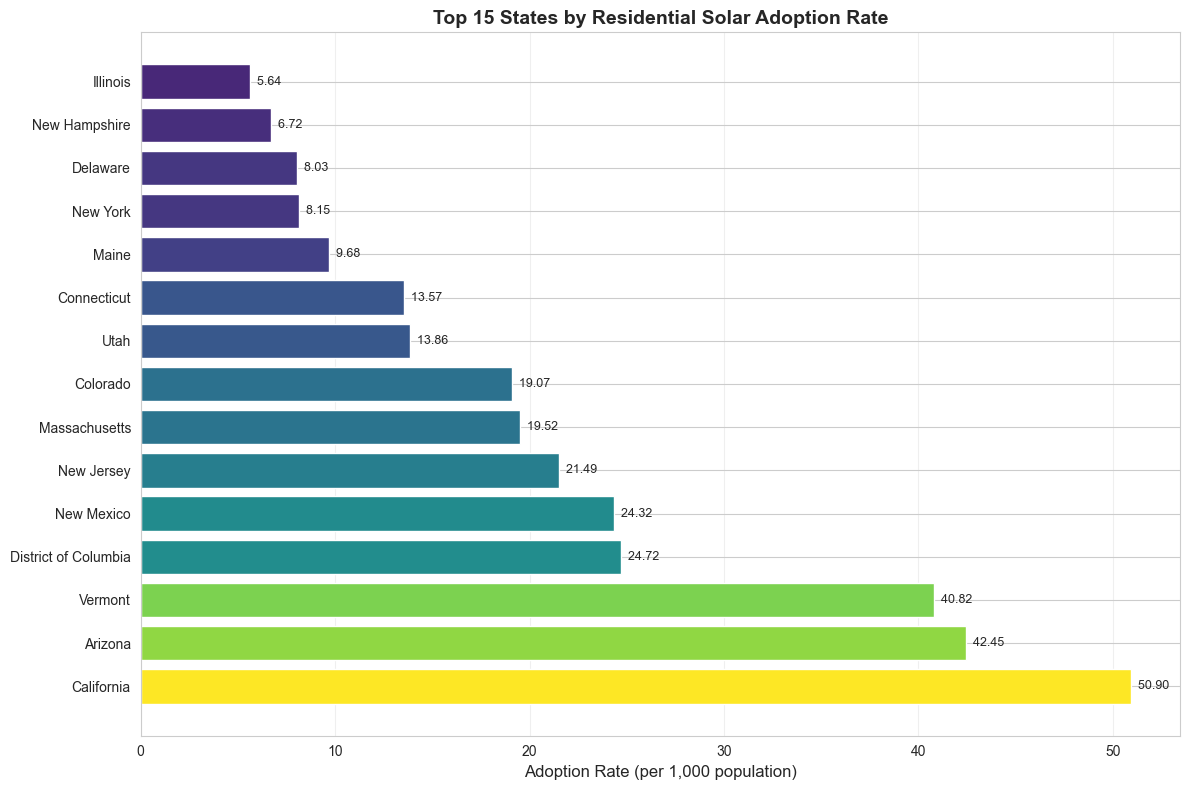


✓ State-level analysis complete!


In [196]:
# Analyze adoption rates by state
print("=" * 70)
print("Solar Adoption Rates by State")
print("=" * 70)

# Check if state_name column exists in merged_df
if 'state_name' in merged_df.columns:
    # Aggregate by state
    state_adoption = merged_df.groupby('state_name').agg({
        'adoption_rate_per_1k_pop': 'mean',
        'installation_count_weighted': 'sum',
        'total_capacity_kw_weighted': 'sum',
        'total_population': 'sum',
        'county_fips': 'count'  # Number of counties per state
    }).reset_index()
    
    # Rename columns for clarity
    state_adoption.columns = ['state_name', 'avg_adoption_rate_per_1k', 
                              'total_installations', 'total_capacity_kw',
                              'total_population', 'num_counties']
    
    # Calculate state-level adoption rate (weighted by population)
    state_adoption['state_adoption_rate_per_1k'] = (
        state_adoption['total_installations'] / 
        state_adoption['total_population'] * 1000
    )
    
    # Sort by adoption rate
    state_adoption = state_adoption.sort_values('state_adoption_rate_per_1k', ascending=False)
    
    print(f"\n📊 Top 20 States by Adoption Rate (per 1,000 population):")
    display_cols = ['state_name', 'state_adoption_rate_per_1k', 'total_installations', 
                    'total_capacity_kw', 'num_counties']
    print(state_adoption[display_cols].head(20).to_string(index=False))
    
    print(f"\n📊 Bottom 10 States by Adoption Rate:")
    print(state_adoption[display_cols].tail(10).to_string(index=False))
    
    print(f"\n📊 Summary Statistics:")
    print(f"  National average: {state_adoption['state_adoption_rate_per_1k'].mean():.2f} per 1k pop")
    print(f"  Median: {state_adoption['state_adoption_rate_per_1k'].median():.2f} per 1k pop")
    print(f"  Highest: {state_adoption['state_adoption_rate_per_1k'].iloc[0]:.2f} ({state_adoption['state_name'].iloc[0]})")
    print(f"  Lowest: {state_adoption['state_adoption_rate_per_1k'].iloc[-1]:.2f} ({state_adoption['state_name'].iloc[-1]})")
    
    # Visualize top 15 states
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    top_15 = state_adoption.head(15)
    colors = plt.cm.viridis(top_15['state_adoption_rate_per_1k'] / top_15['state_adoption_rate_per_1k'].max())
    
    ax.barh(range(len(top_15)), top_15['state_adoption_rate_per_1k'], color=colors)
    ax.set_yticks(range(len(top_15)))
    ax.set_yticklabels(top_15['state_name'])
    ax.set_xlabel('Adoption Rate (per 1,000 population)', fontsize=12)
    ax.set_title('Top 15 States by Residential Solar Adoption Rate', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(top_15['state_adoption_rate_per_1k']):
        ax.text(v, i, f'  {v:.2f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ State-level analysis complete!")
    
else:
    print("⚠️  state_name column not found in merged_df")
    print(f"   Available columns: {merged_df.columns.tolist()}")

In [193]:
# Plot distribution of adoption rate

# Get top counties by adoption rate per 1,000 population
print("=" * 70)
print("Top Counties by Residential Solar Adoption Rate")
print("=" * 70)

# Check if NAME column exists in merged_df
if 'NAME' in merged_df.columns:
    # Sort by adoption rate and get top counties
    top_counties = merged_df.nlargest(20, 'adoption_rate_per_1k_pop')
    
    # Display key columns
    display_cols = ['NAME', 'county_fips', 'adoption_rate_per_1k_pop', 
                    'installation_count_weighted', 'total_population', 
                    'median_household_income', 'urbanicity']
    
    available_cols = [col for col in display_cols if col in top_counties.columns]
    
    print(f"\nTop 20 Counties by Adoption Rate (per 1,000 population):")
    print(top_counties[available_cols].to_string(index=False))
    
    # Summary statistics
    print(f"\n📊 Summary:")
    print(f"  Highest adoption rate: {top_counties['adoption_rate_per_1k_pop'].iloc[0]:.2f} per 1k pop")
    print(f"  County: {top_counties['NAME'].iloc[0]}")
    print(f"  Average adoption (top 20): {top_counties['adoption_rate_per_1k_pop'].mean():.2f} per 1k pop")
    
    # Show urbanicity distribution in top 20
    if 'urbanicity' in top_counties.columns:
        print(f"\n  Urbanicity breakdown (top 20):")
        print(top_counties['urbanicity'].value_counts())
    
else:
    print("⚠️  NAME column not found in merged_df")
    print(f"   Available columns: {merged_df.columns.tolist()}")

Top Counties by Residential Solar Adoption Rate

Top 20 Counties by Adoption Rate (per 1,000 population):
                              NAME  county_fips  adoption_rate_per_1k_pop  installation_count_weighted  total_population  median_household_income urbanicity
      El Dorado County, California         6017                129.781351                 24956.823936          192299.0                 106190.0      Rural
      Calaveras County, California         6009                120.318376                  5534.043689           45995.0                  79877.0      Rural
           Yuba County, California         6115                118.803355                  9870.063911           83079.0                  73313.0      Rural
         Amador County, California         6005                107.148019                  4396.176064           41029.0                  81526.0      Rural
         Sutter County, California         6101                106.408941                 10531.399337       

In [190]:
# Select features for modeling
modeling_features = [
    # TARGET 
    'adoption_rate_per_1k_pop',
    'log_adoption_rate_pop',
    'total_capacity_kw_weighted',
    
    
    # PREDICTORS: Affordability/Financing
    'median_household_income',
    
    # PREDICTORS: Structural Feasibility
    'homeownership_rate',
    'single_family_home_pct',
    
    # PREDICTORS: Demographics
    'pct_bachelors_or_higher',
    'pct_white_non_hispanic',
    'pct_black',
    'pct_hispanic',
    'avg_household_size',
    
    # PREDICTORS: Geography/Physical
    'population_density',
    'urbanicity',  # categorical

    
    # PREDICTORS: Policy
    'has_net_metering',
    'has_solar_incentive',
    'total_solar_programs',

    # CONTROL
    'avg_daily_sunlight'
]

# Create clean modeling dataset
model_df = merged_df[modeling_features].copy()

print(f"✅ Modeling dataset: {model_df.shape}")
print(f"   Features: {model_df.shape[1] - 1}")  # -1 for target
print(f"   Observations: {len(model_df):,}")

✅ Modeling dataset: (1279, 17)
   Features: 16
   Observations: 1,279


In [191]:
# Save to csv
model_df.to_csv('modeling_data/merged_solar_dataset.csv', index=False)